# Legendary Pokémon Classifier
#### Goals:
- Gain experience working with imbalanced data
- Use EDA to learn which features can be used to differentiate legendary and non-legendary Pokémon
- Build a model that can accurately predict if a Pokémon is legendary

#### Orginal dataset from [here](https://www.kaggle.com/datasets/rounakbanik/pokemon)
*The orginal dataset had numerous inccorect values so this is an updated dataset (that has been cleaned and modified) with correct values.*<br>
**NOTE: This is my first time building and anaylsing ML models.**


## Contents:
* [-- Imports](#Imports)
* [1. EDA](#1.-EDA)
* [2. Preprocessing](#2.-Preprocessing)
    * [Over-sampling](#Over-sampling)
* [3. Model Selection](#3.-Model-Selection)
    * [Helper Functions](#Helper-Functions)
    * [Logisitic Regression](#Logistic-Regression)
        * [Baseline Metrics](#Baseline-Metrics)
        * [Manual Parameter Tuning](#Manual-Parameter-Tuning)
        * [Grid Search](#Grid-Search)
    * [XGBClassifier](#XBGClassifier)
        * [Randomized Grid Search](#Randomized-Grid-Search)
        * [Feature Importance](#Feature-Importance)
* [4. Compare Models](#4.-Compare-Models)
* [5. Interface Demo](#5.-Interface-Demo)
* [6. Conclusion](#6Conclusion)

#### Imports

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------------------------------------------------------------------------
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (classification_report, mean_squared_error, confusion_matrix, f1_score, log_loss,
precision_score, recall_score, roc_curve, auc)

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

# Models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [131]:
df = pd.read_csv('../COMPLETED_pokemon.csv')

In [132]:
df.head(5)

,name,japanese_name,pokedex_number,generation,type1,type2,fully_evolved,weight_kg,height_m,hp,...,against_grass,against_ground,against_ice,against_normal,against_poison,against_psychic,against_rock,against_steel,against_water,is_legendary
0,Bulbasaur,Fushigidaneフシギダネ,1,1,grass,poison,0,6.9,0.7,45,...,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,0
1,Ivysaur,Fushigisouフシギソウ,2,1,grass,poison,0,13.0,1.0,60,...,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,0
2,Venusaur,Fushigibanaフシギバナ,3,1,grass,poison,1,100.0,2.0,80,...,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,0
3,Charmander,Hitokageヒトカゲ,4,1,fire,NT2,0,8.5,0.6,39,...,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0,0
4,Charmeleon,Lizardoリザード,5,1,fire,NT2,0,19.0,1.1,58,...,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0,0


### 1. EDA

In [133]:
df.columns

Index(['name', 'japanese_name', 'pokedex_number', 'generation', 'type1',
       'type2', 'fully_evolved', 'weight_kg', 'height_m', 'hp', 'attack',
       'defense', 'sp_attack', 'sp_defense', 'speed', 'base_total',
       'capture_rate', 'exp_growth', 'base_happiness', 'base_egg_steps',
       'percentage_male', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'is_legendary'],
      dtype='object')

The main features I'll be focusing on are Pokémon stats (height, weight, hp, attack, defense, etc.) which provide a wider range of information than say, type weakness.

In [134]:
key_features = df.loc[:, 'type1':'percentage_male'].columns.to_list()
key_features

['type1',
 'type2',
 'fully_evolved',
 'weight_kg',
 'height_m',
 'hp',
 'attack',
 'defense',
 'sp_attack',
 'sp_defense',
 'speed',
 'base_total',
 'capture_rate',
 'exp_growth',
 'base_happiness',
 'base_egg_steps',
 'percentage_male']

In [135]:
l = df[df['is_legendary'] == 1]  # legendary Pokémon
nl = df[df['is_legendary'] == 0]  # non-legendary Pokémon

print(f"{len(l)} marked as legendary\n{len(nl)} marked as non-legendary.")

72 marked as legendary
729 marked as non-legendary.


There's a heavy imbalance between legendary and non-legendary Pokémon.

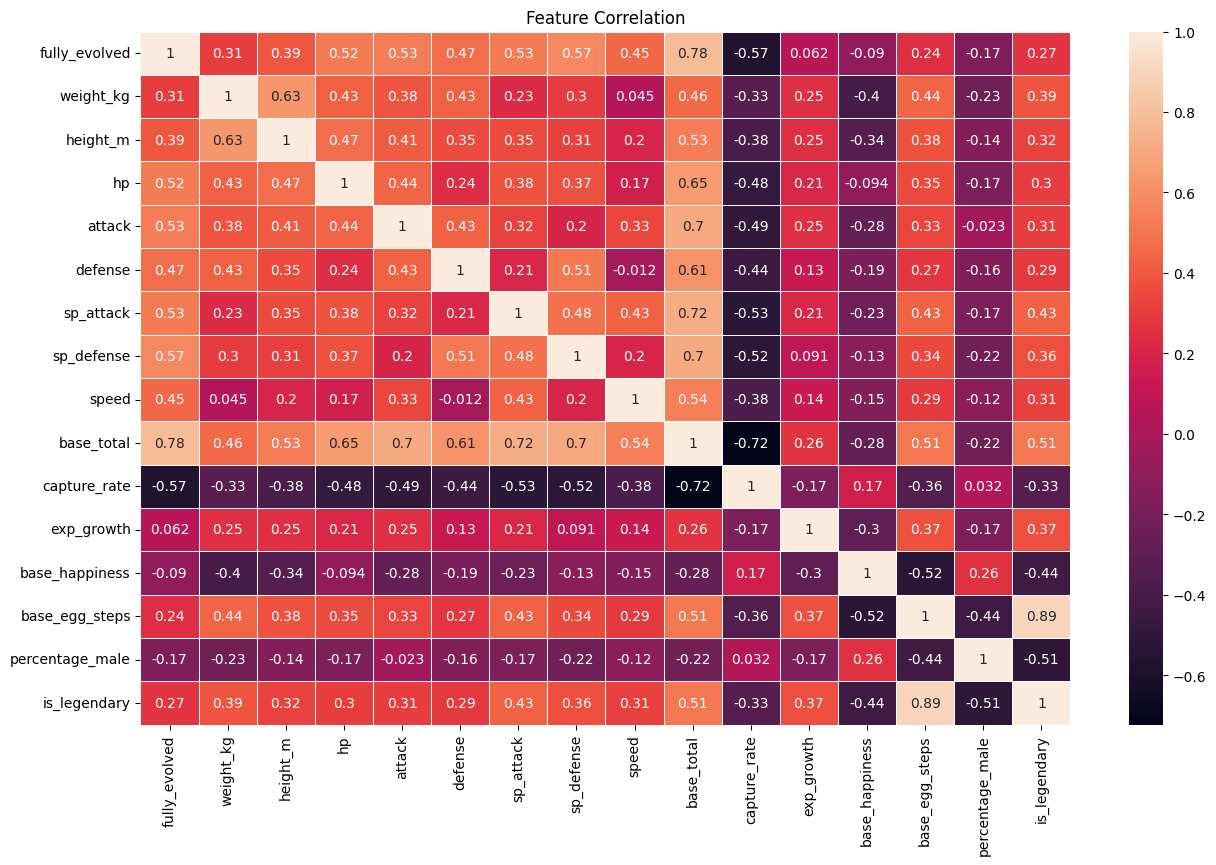

In [136]:
# feature collelation
key_features.append('is_legendary')
corr = df[key_features].select_dtypes('number').corr()

f, ax = plt.subplots(figsize=(15, 9))
plt.title('Feature Correlation')
sns.heatmap(corr, annot=True, ax=ax, cmap='rocket', linewidth=.5)
del key_features[-1]
plt.show()

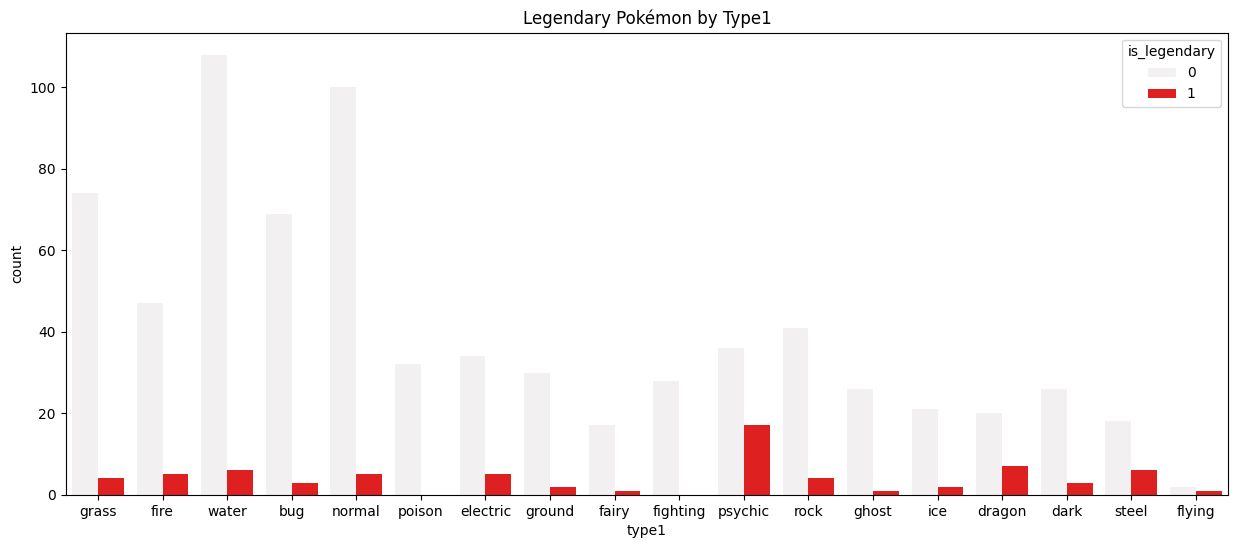

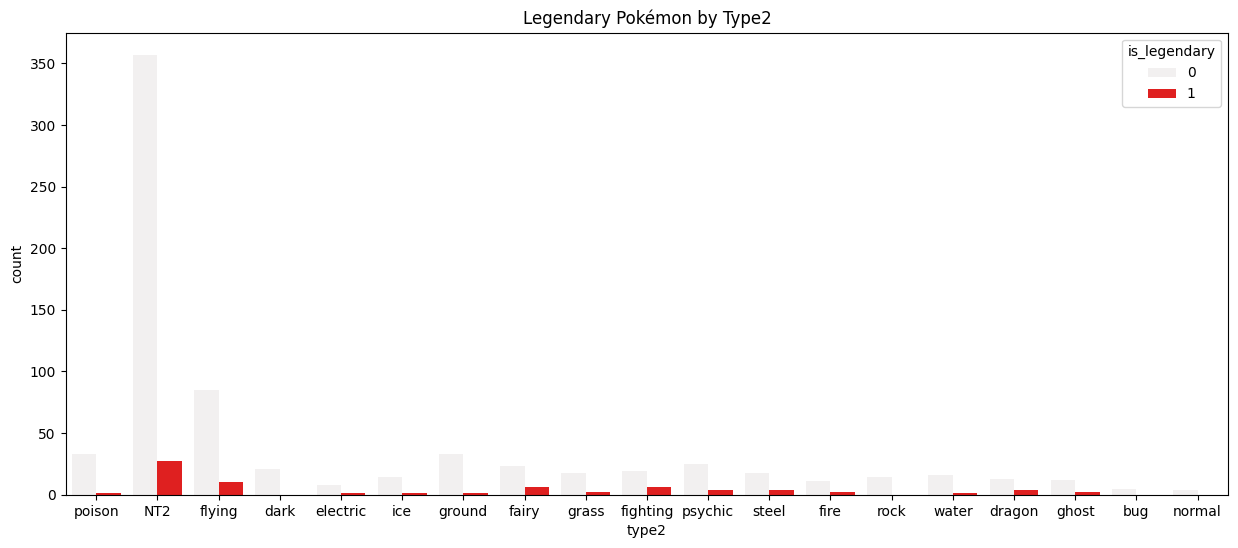

In [137]:
# legendaries by type
for feature in ['type1', 'type2']:
    f, ax = plt.subplots(1, 1, figsize=(15, 6))
    ax.set_title(f'Legendary Pokémon by {feature.title()}')
    sns.countplot(x=df[feature], hue=df['is_legendary'], ax=ax, color='red')
    plt.show()

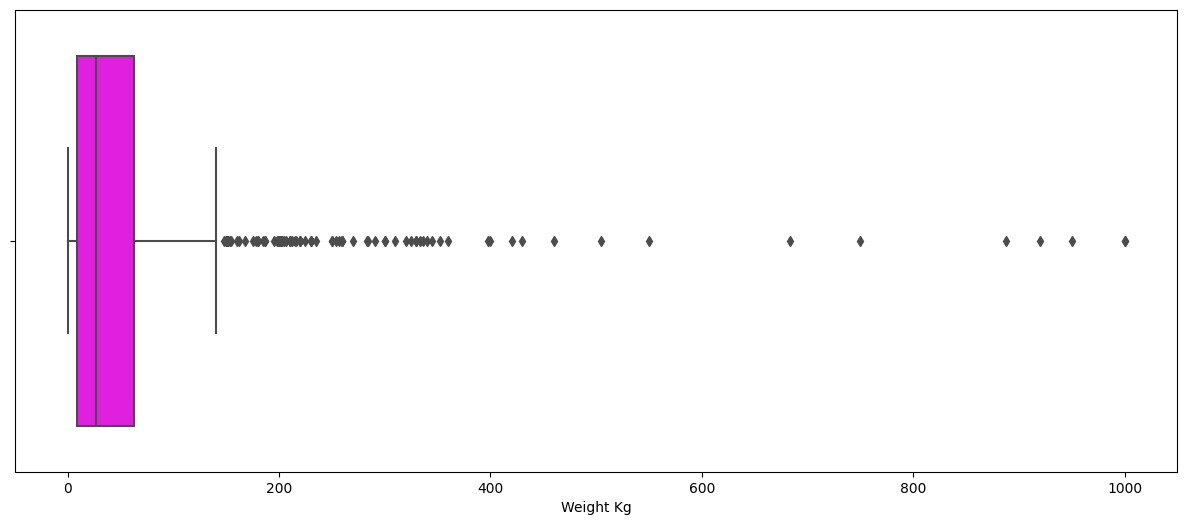

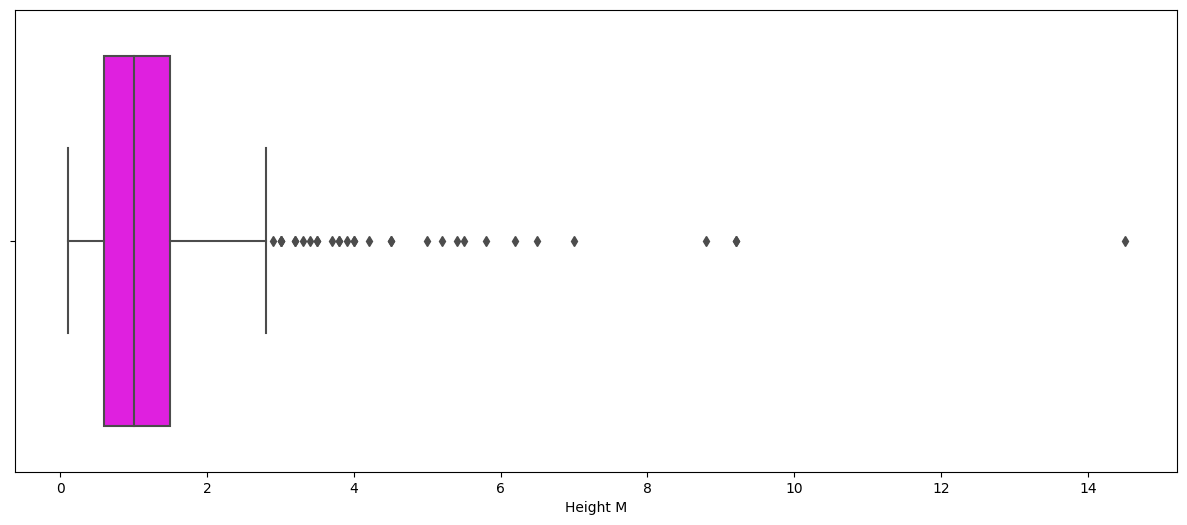

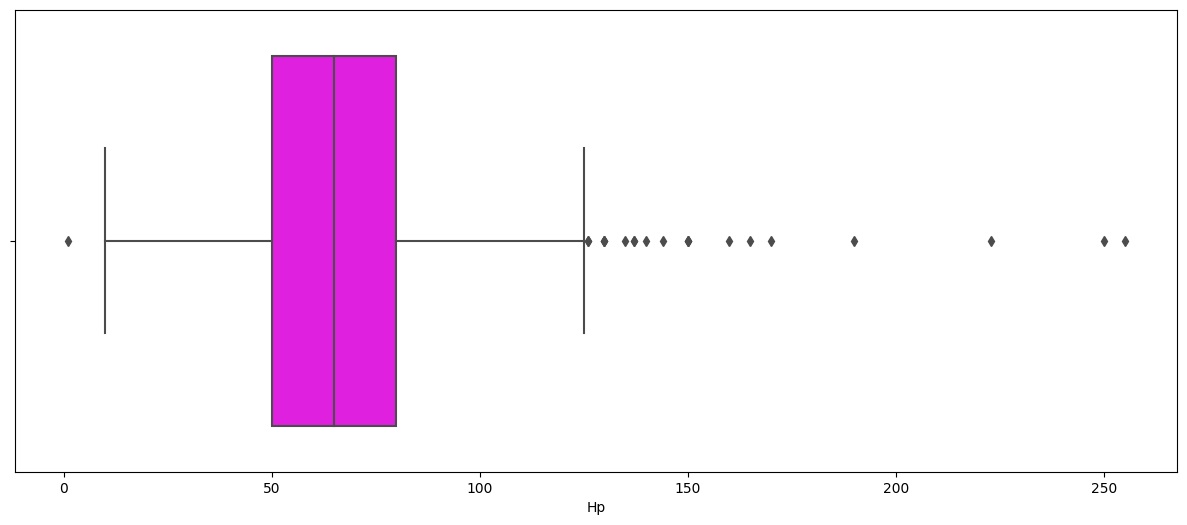

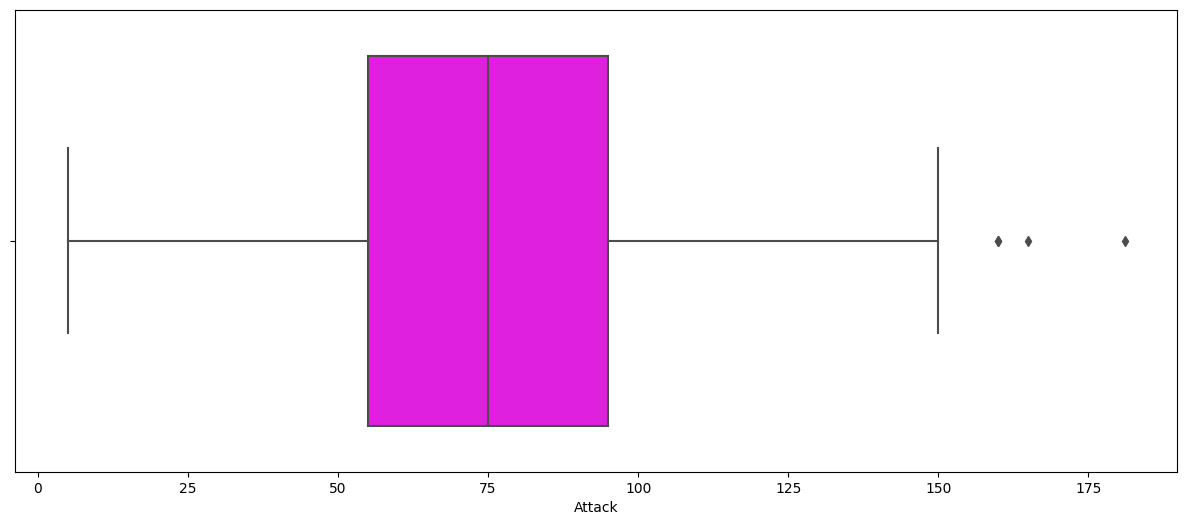

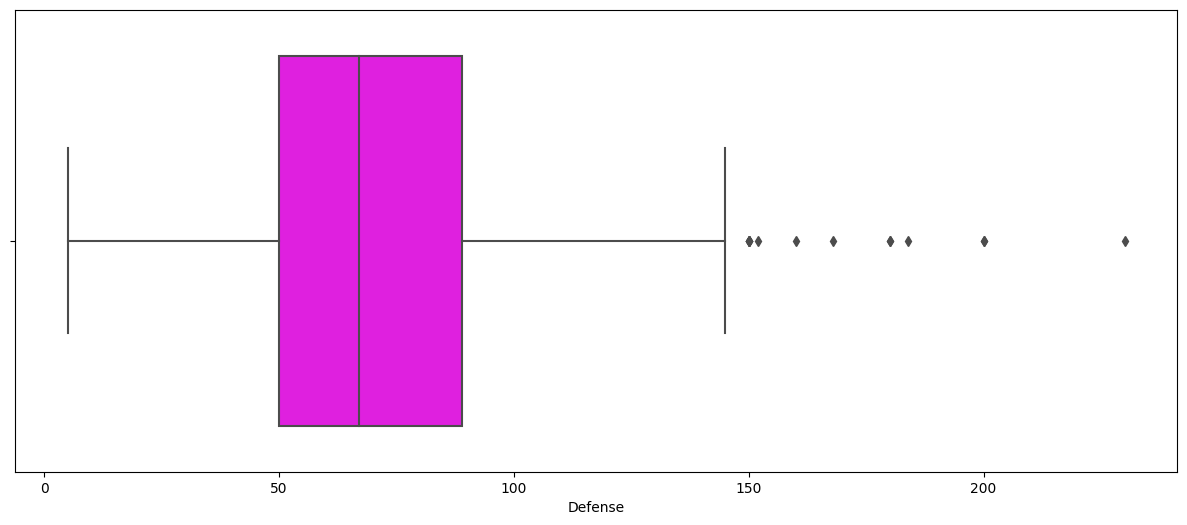

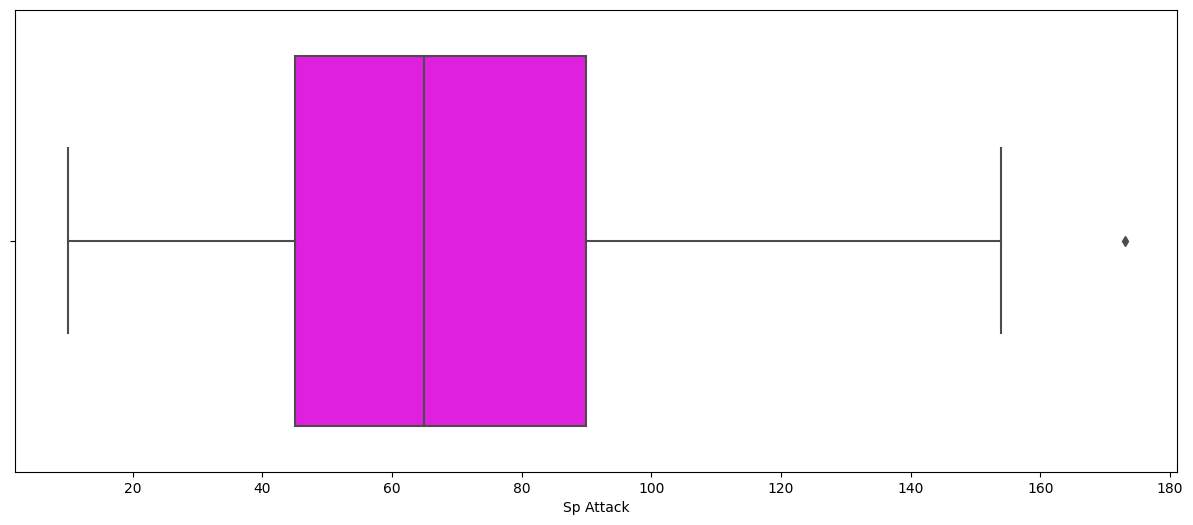

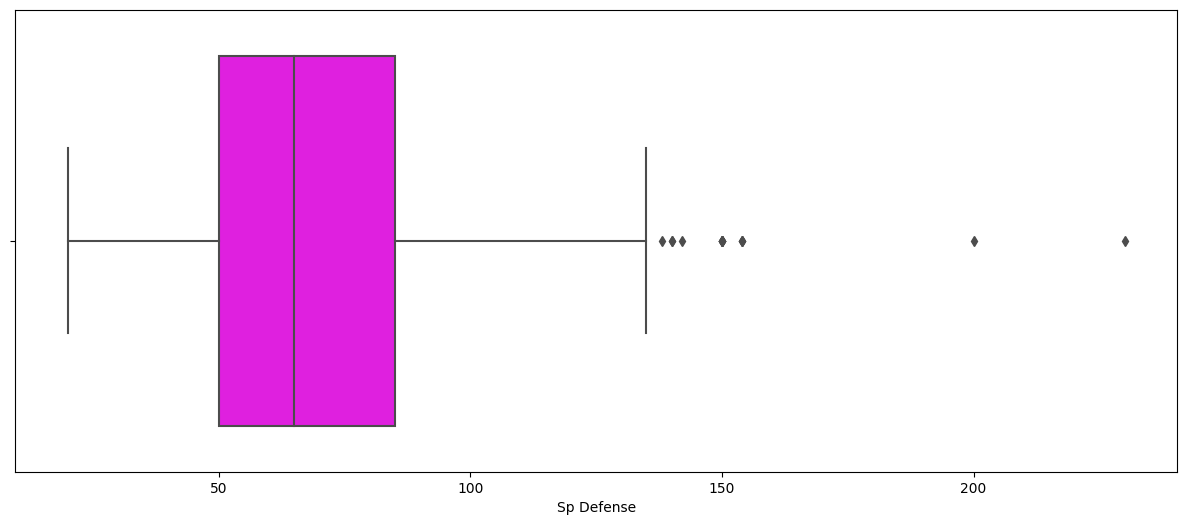

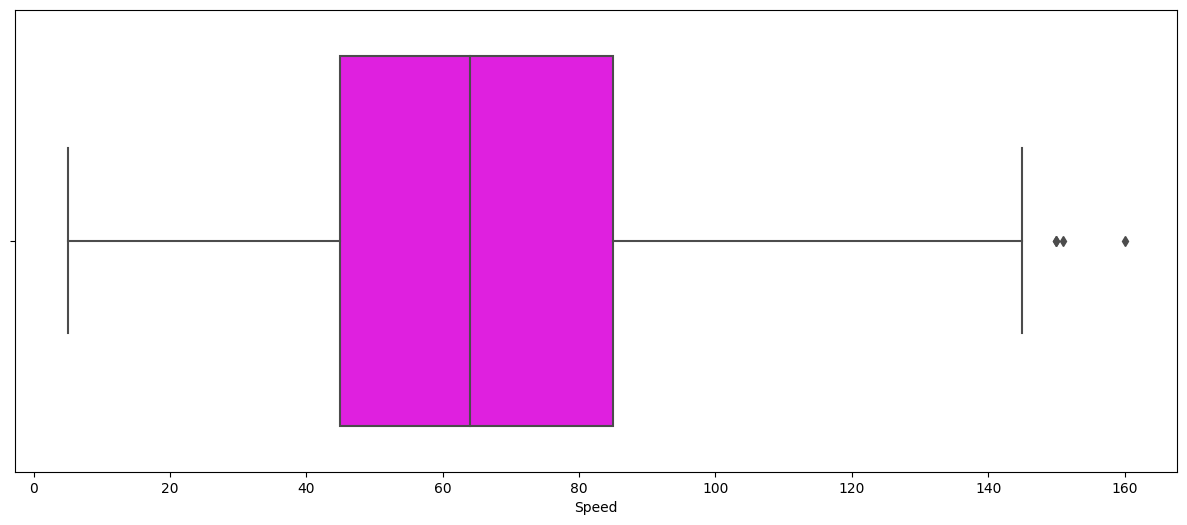

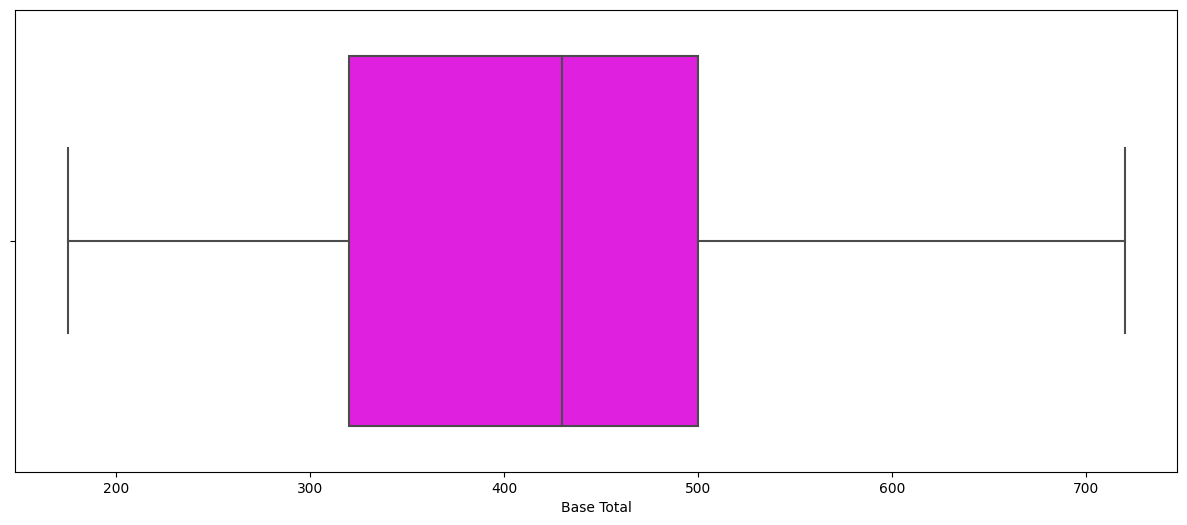

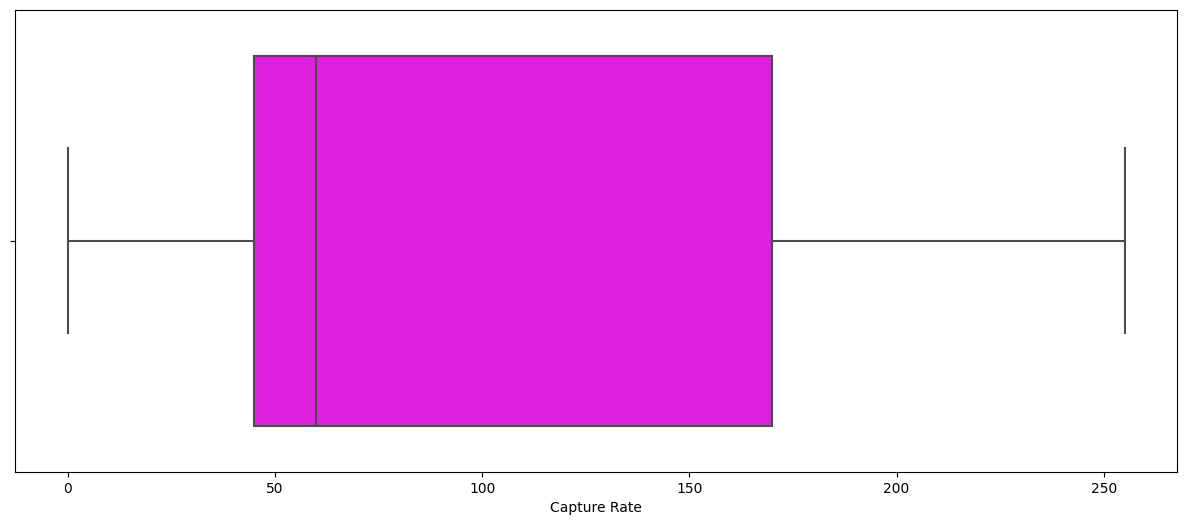

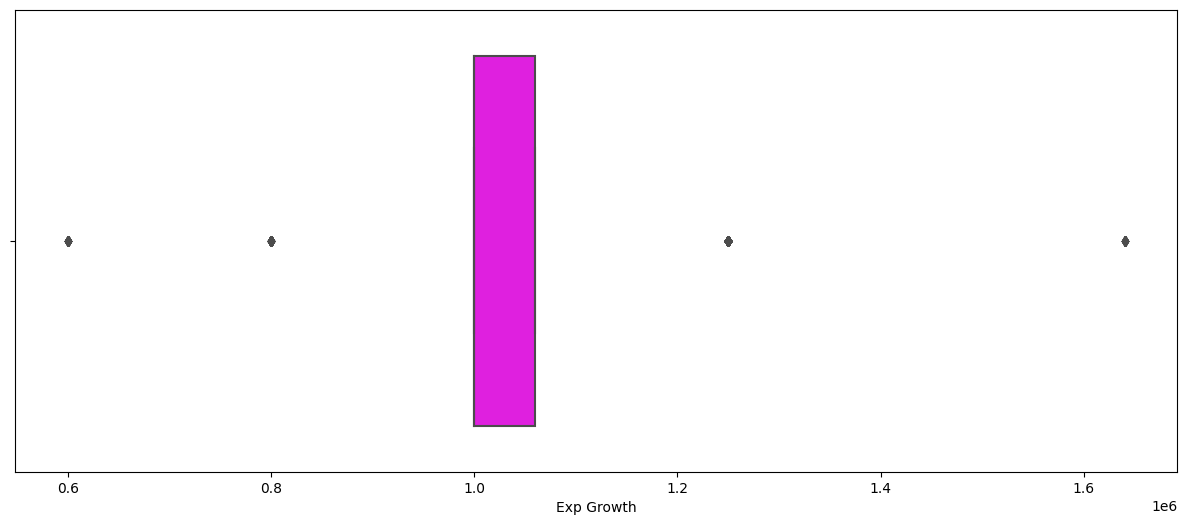

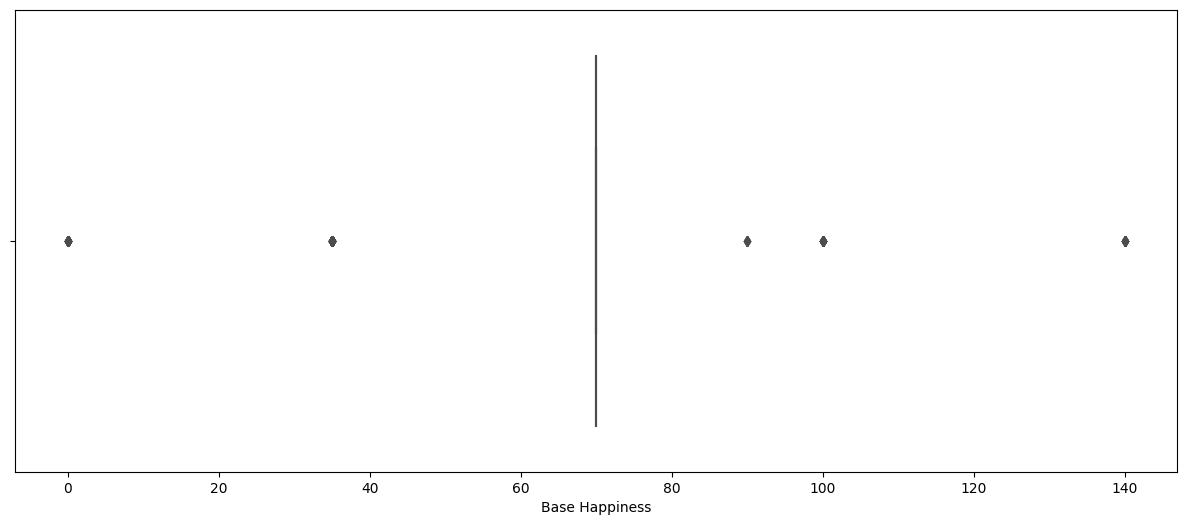

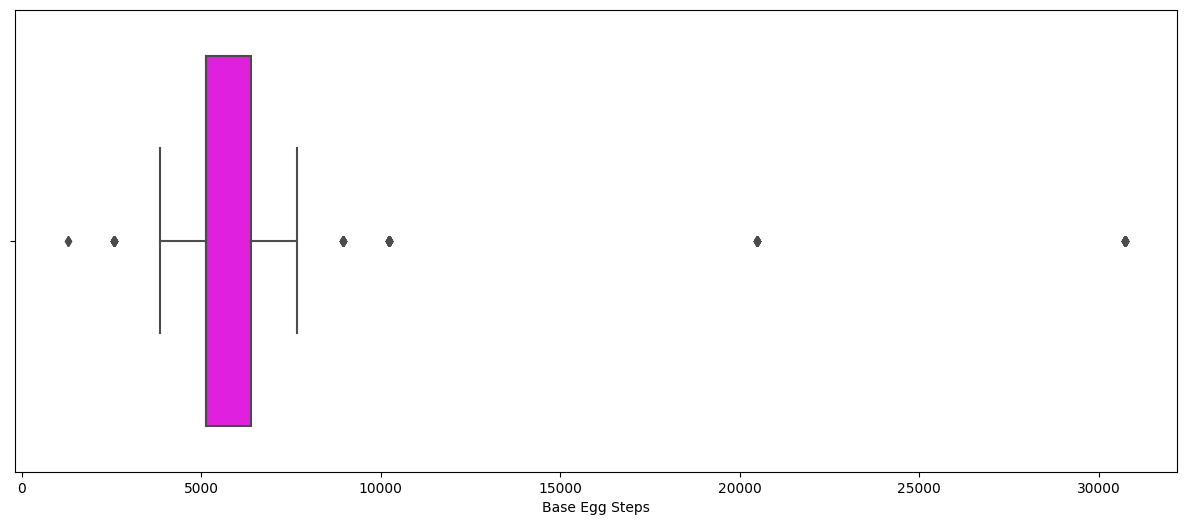

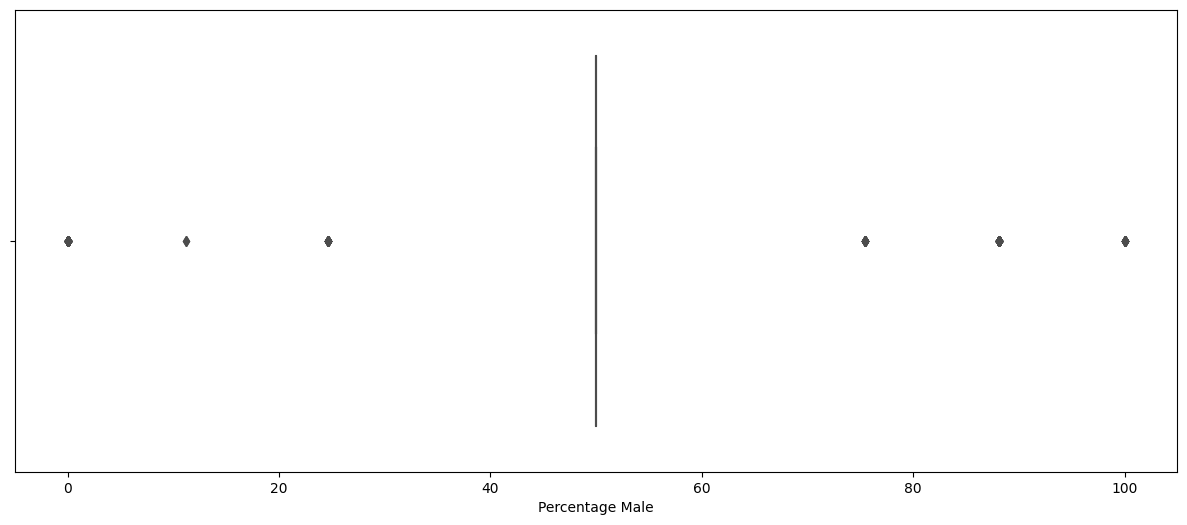

In [138]:
# checking outliers
for feature in key_features[3:]:
    f, ax = plt.subplots(figsize=(15, 6))
    x = df[feature]
    x_label = feature.title().replace('_', ' ')
    sns.boxplot(x=x, color='magenta', ax=ax)
    plt.xlabel(x_label)
    plt.show()

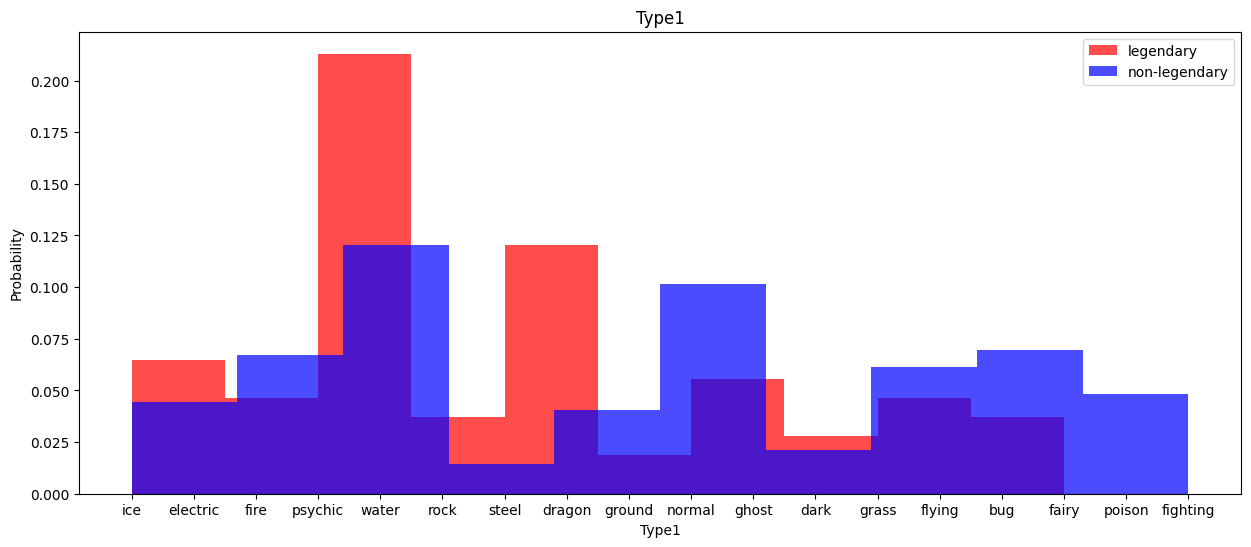

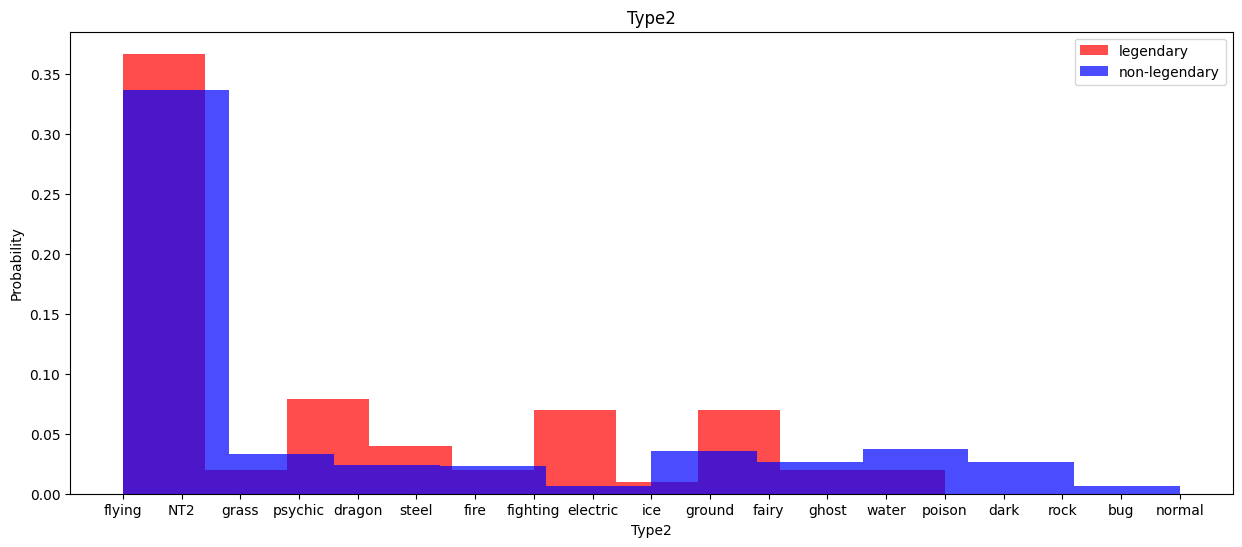

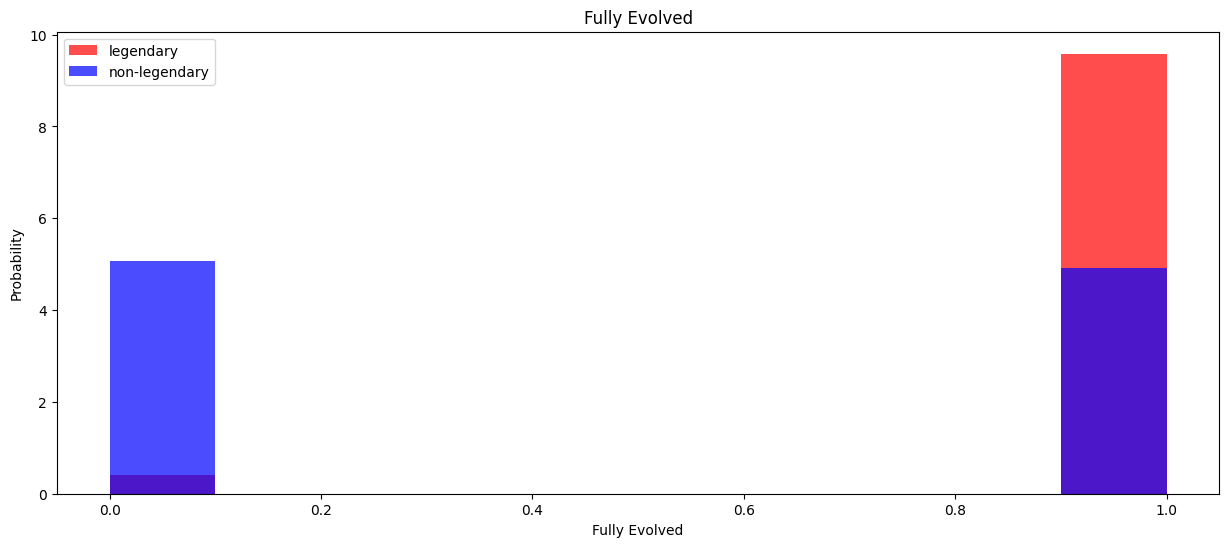

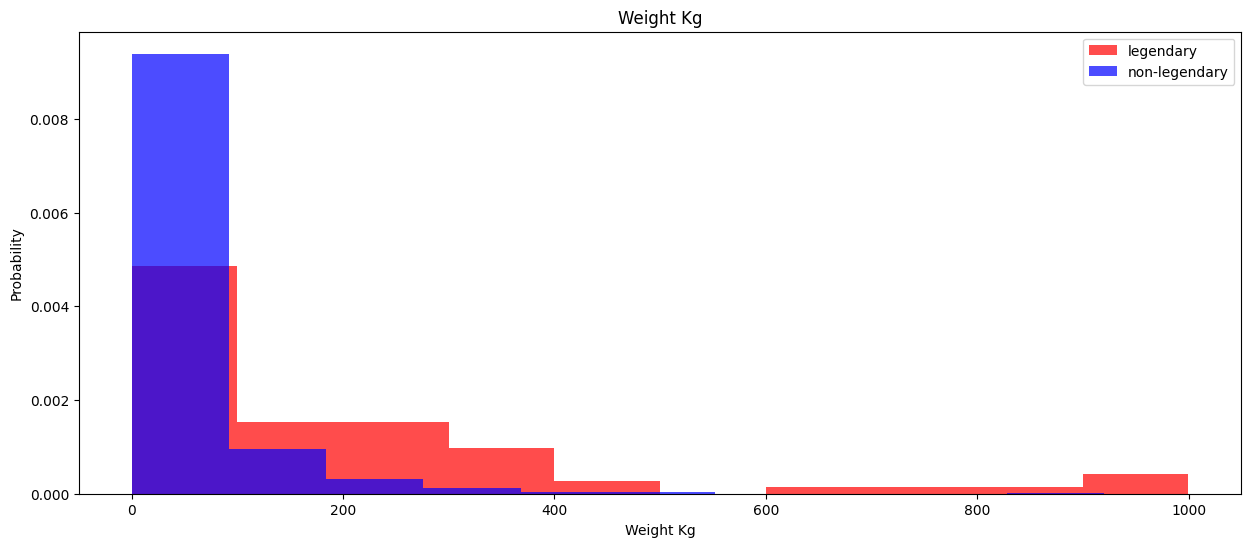

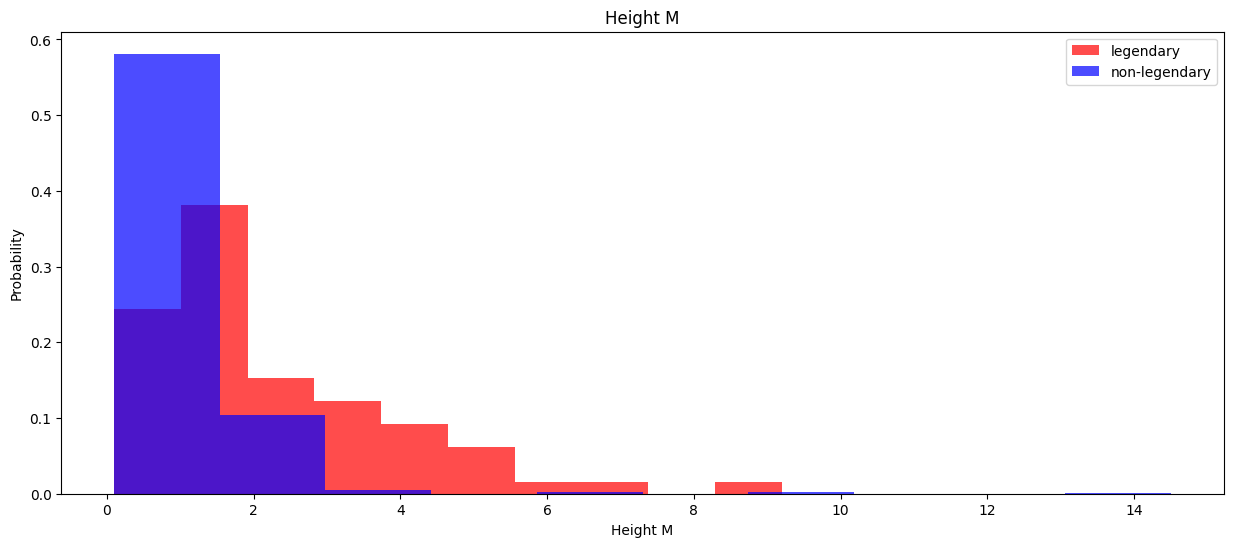

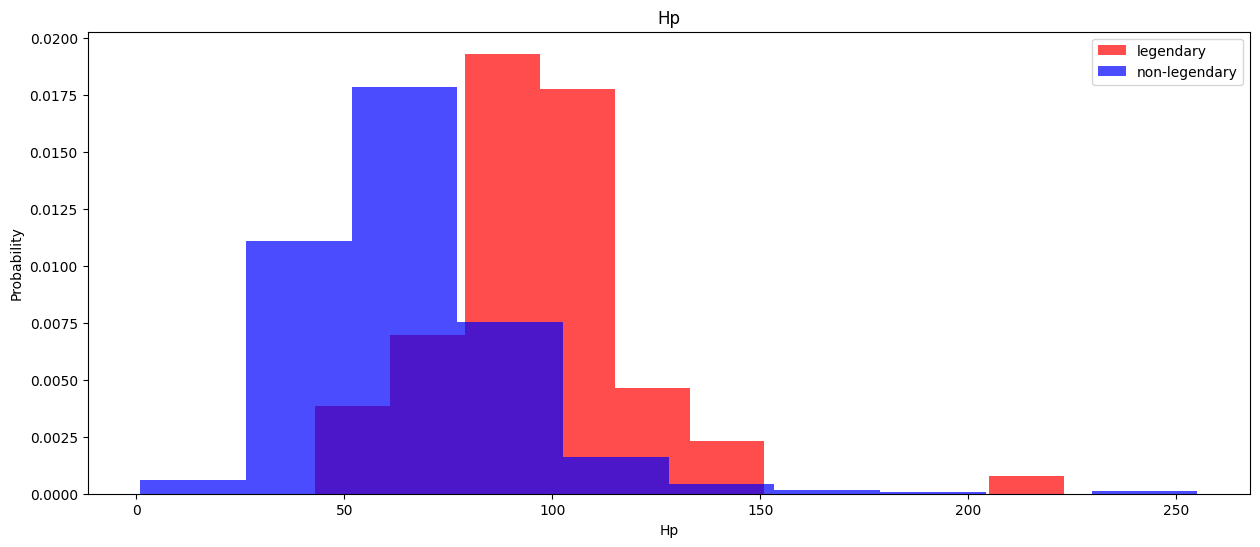

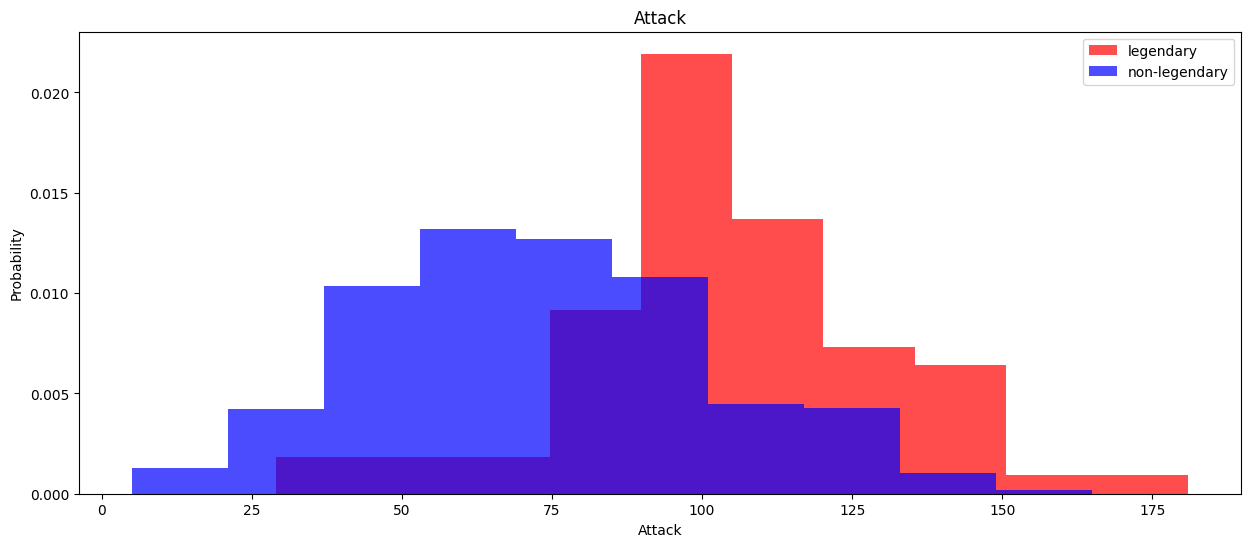

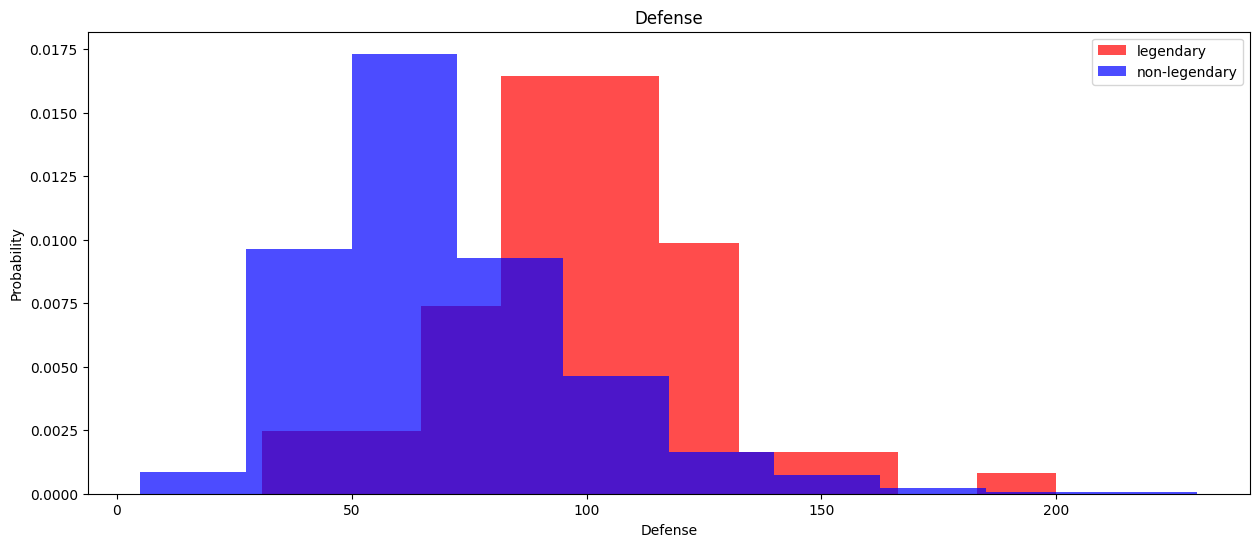

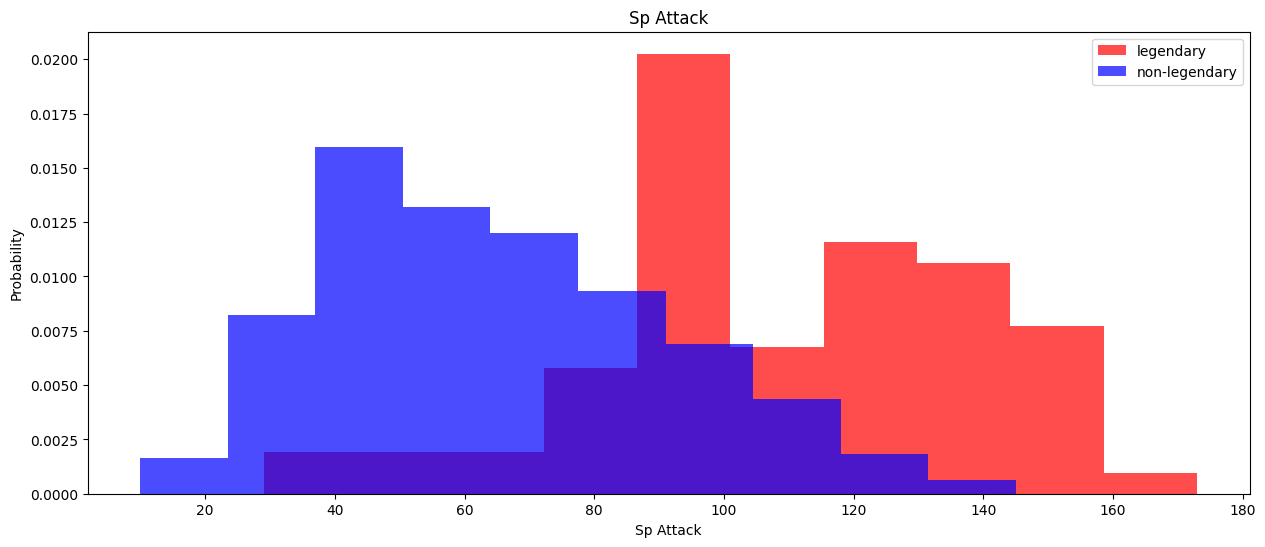

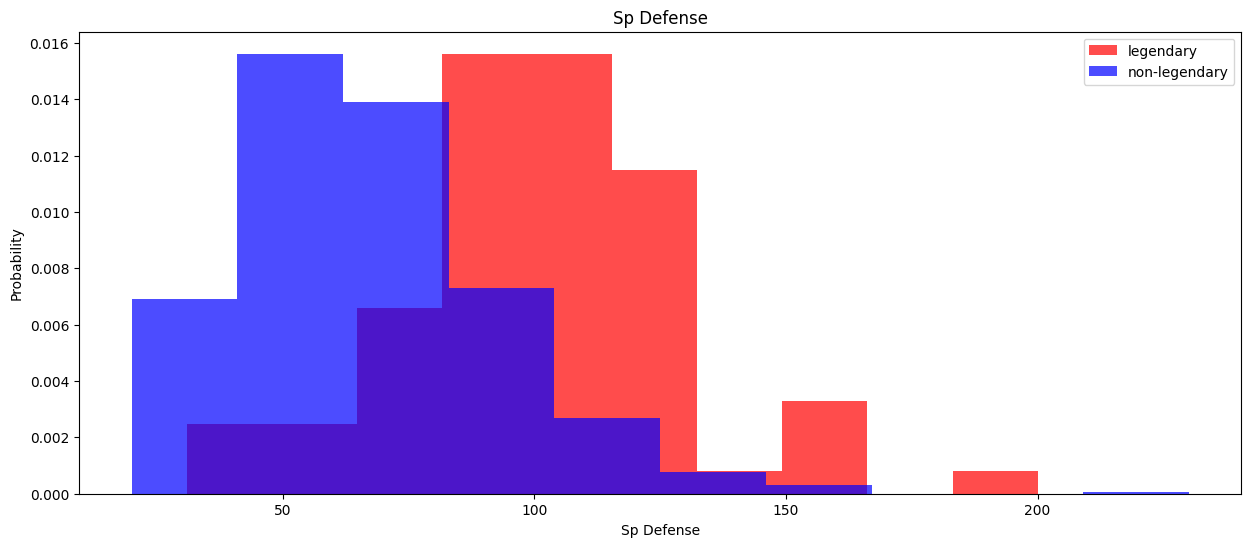

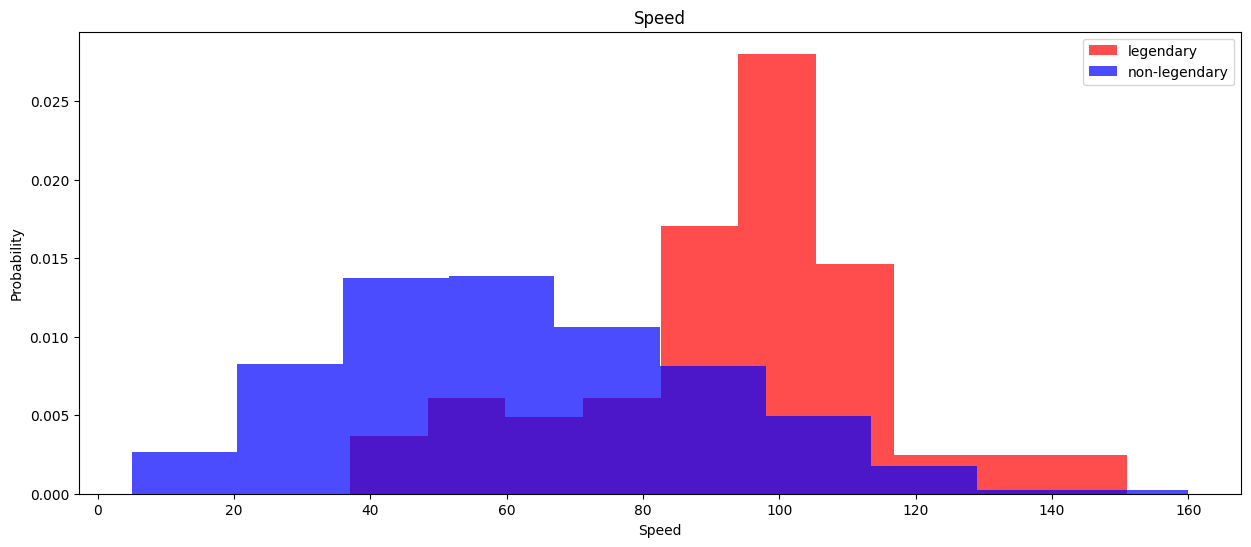

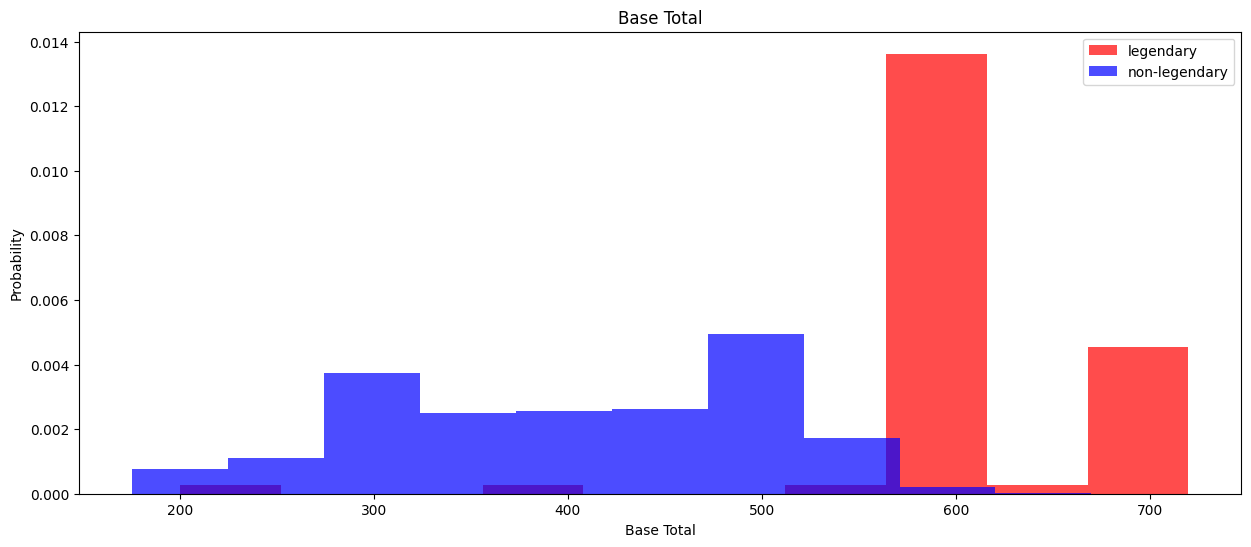

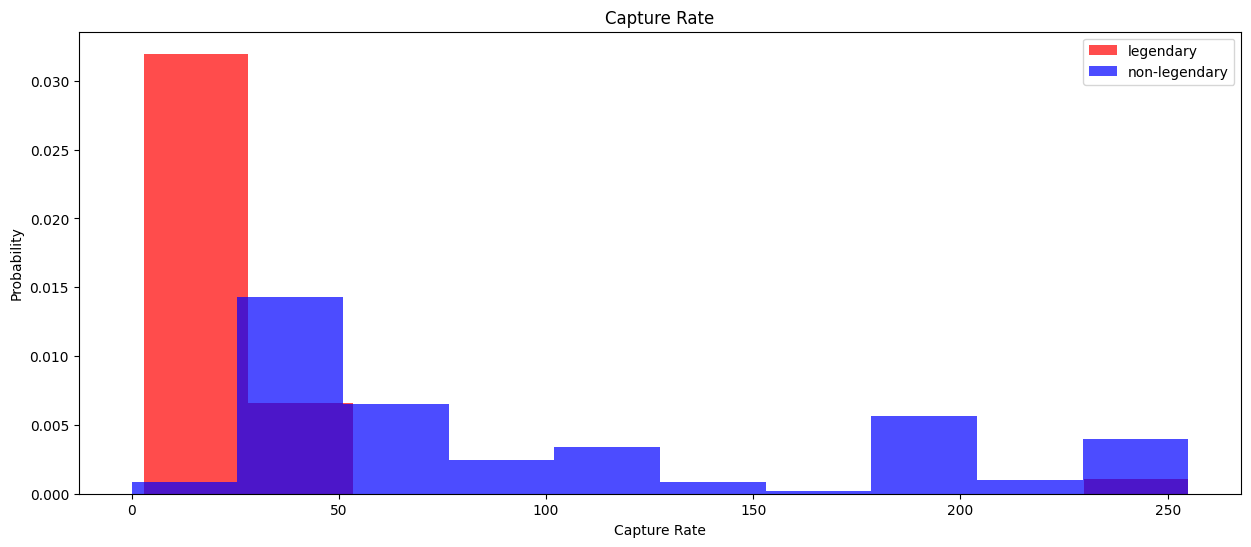

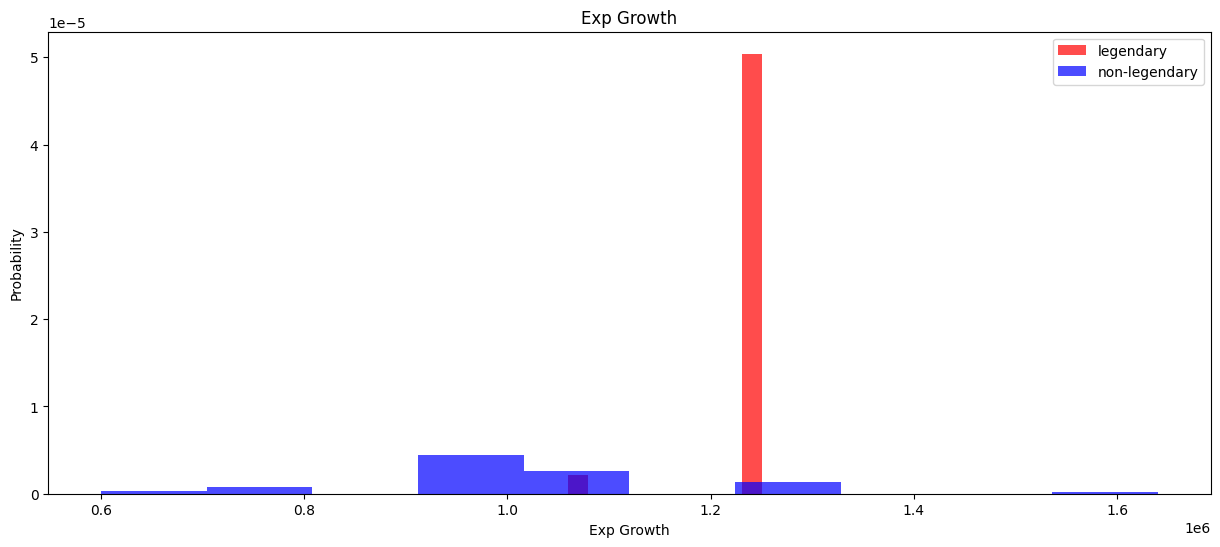

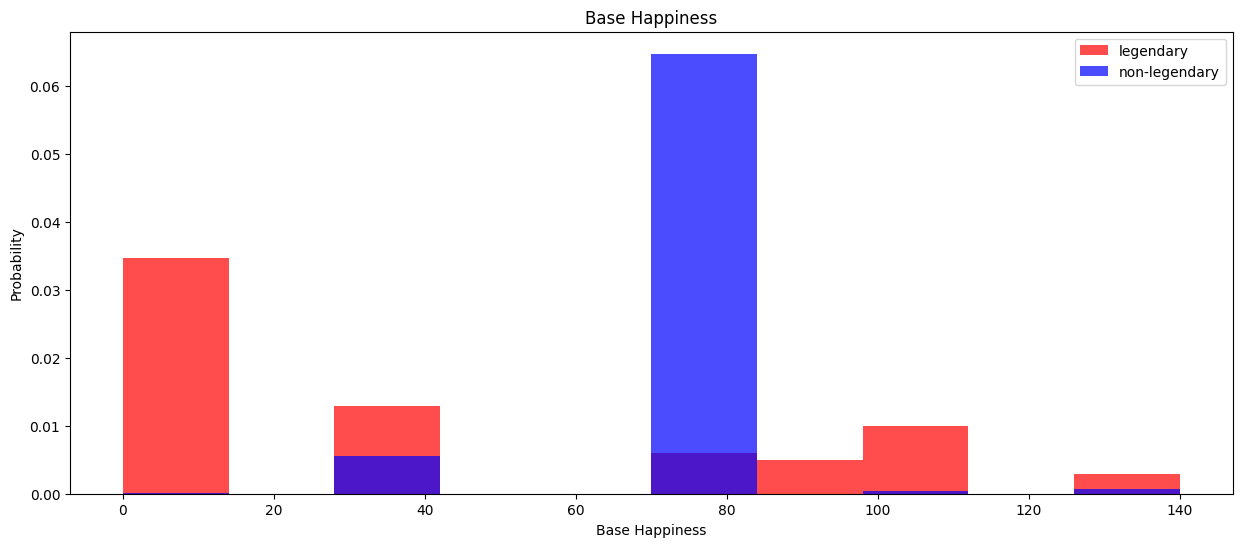

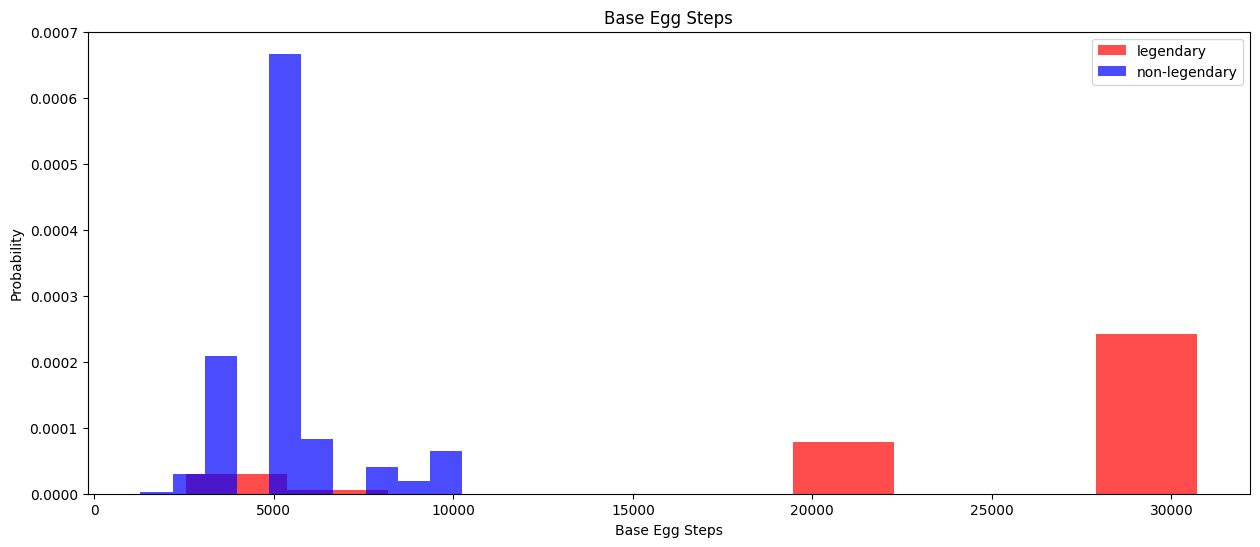

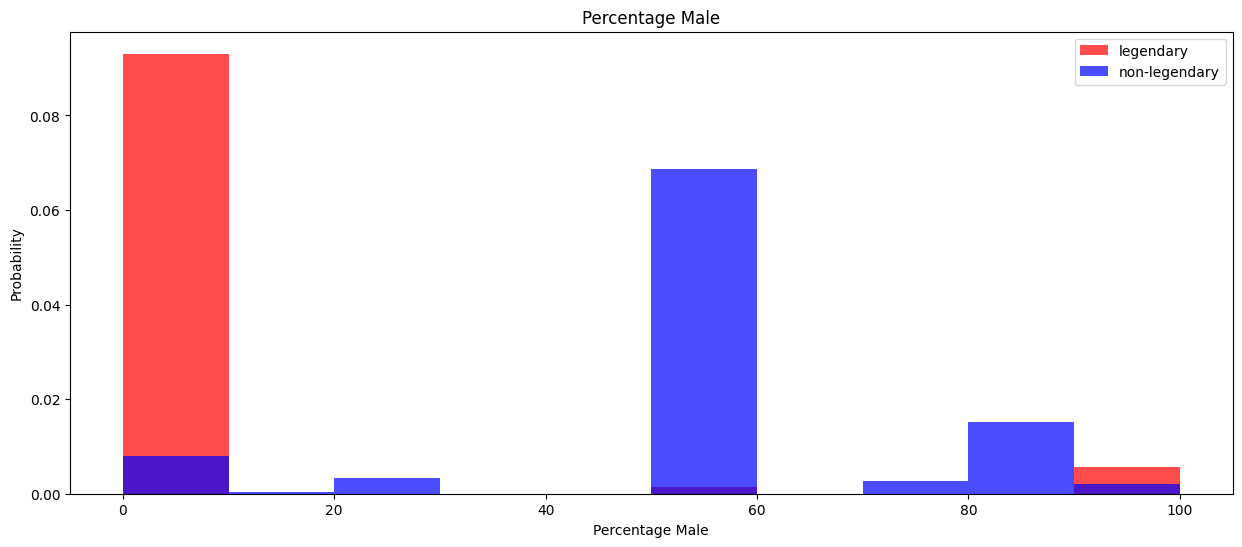

In [139]:
# histogram plots
for f in key_features:
    plt.figure(figsize=(15, 6))
    stat_string = f.title().replace('_', ' ')
    plt.title(stat_string)
    plt.hist(l[f], label='legendary', color='r', alpha=0.7, density=True)
    plt.hist(nl[f], label='non-legendary', color='b', alpha=0.7, density=True)
    plt.xlabel(stat_string)
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

### 2. Preprocessing

In [140]:
# one hot encode Pokémon types
df_ohe = pd.get_dummies(df, columns=['type1', 'type2'])
key_features = [col for col in df_ohe.columns[4:] if 'against' not in col and 'legendary' not in col]

In [141]:
# select features for training set
X, y = df_ohe[key_features], df_ohe['is_legendary']

print(f"Shape of X is: {X.shape}")
print(f"Shape of y is: {y.shape}")

Shape of X is: (801, 52)
Shape of y is: (801,)


In [142]:
# split training/test sets
X_train, x_, y_train, y_ = train_test_split(X, y, test_size=0.20, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.20, random_state=42)

# delete temporary variables
del x_, y_

print(f"Shape of X_train is: {X_train.shape}")
print(f"Shape of y_train is: {y_train.shape}")
print(f"Shape of X_cv is: {X_cv.shape}")
print(f"Shape of y_cv is: {y_cv.shape}")
print(f"Shape of X_test is: {X_test.shape}")
print(f"Shape of y_test is: {y_test.shape}")

Shape of X_train is: (640, 52)
Shape of y_train is: (640,)
Shape of X_cv is: (128, 52)
Shape of y_cv is: (128,)
Shape of X_test is: (33, 52)
Shape of y_test is: (33,)


#### Over-sampling
As mentioned earlier, there are only 70 Pokémon classified as legendary –– which makes the dataset highly skewed toward non-legendary Pokémon. I'll use over-sampling on my training set to try negate that.

In [143]:
print(f"{sum(y_train == 1)} are legendary in y_train")
print(f"{sum(y_train == 0)} are not legendary in y_train")

54 are legendary in y_train
586 are not legendary in y_train


In [144]:
from imblearn.over_sampling import RandomOverSampler

old_X, old_y = X_train, y_train  # for plotting purposes

ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(X_train, y_train)

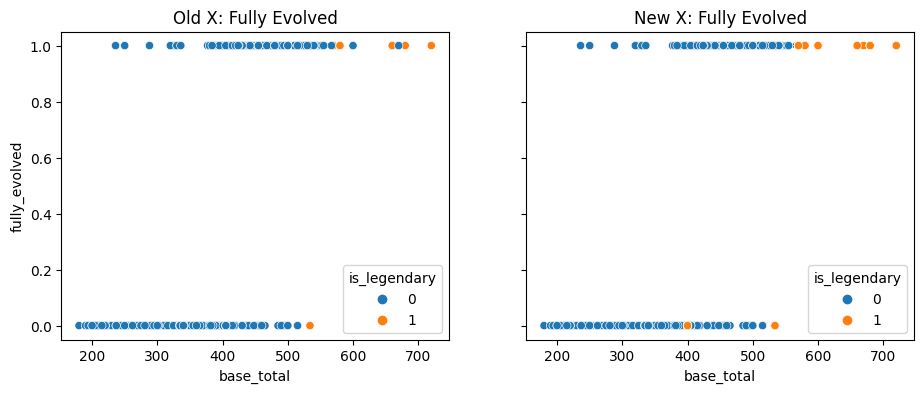

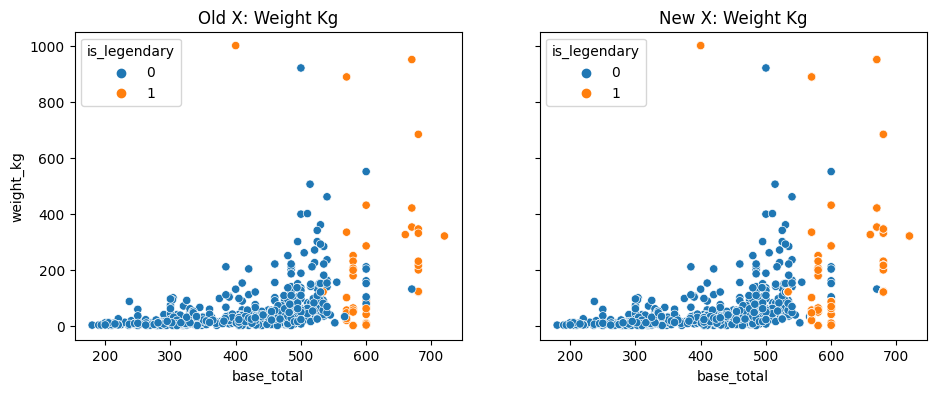

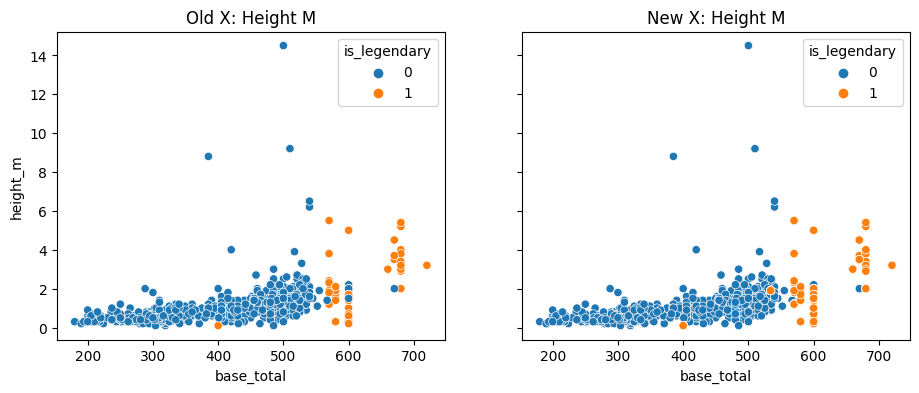

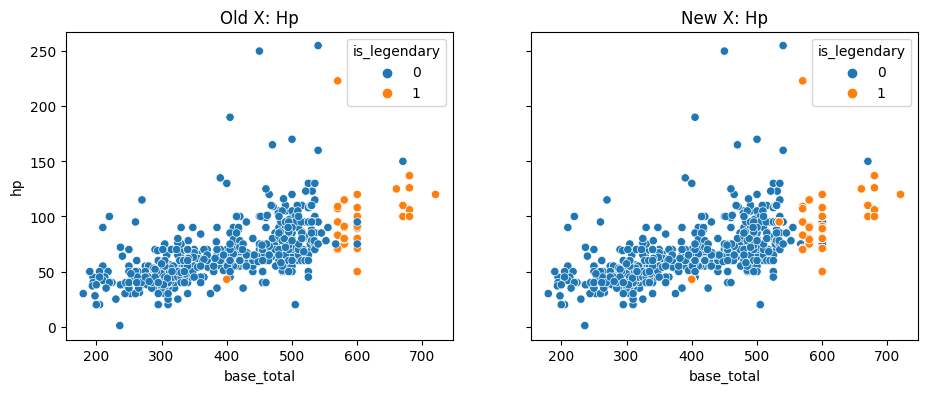

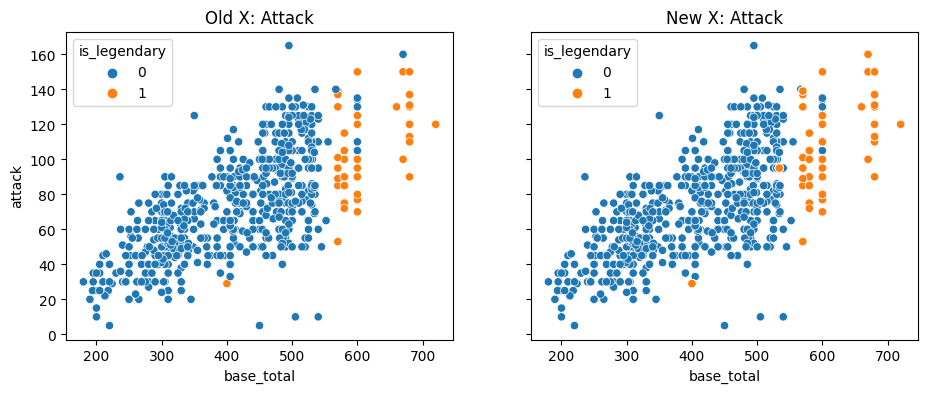

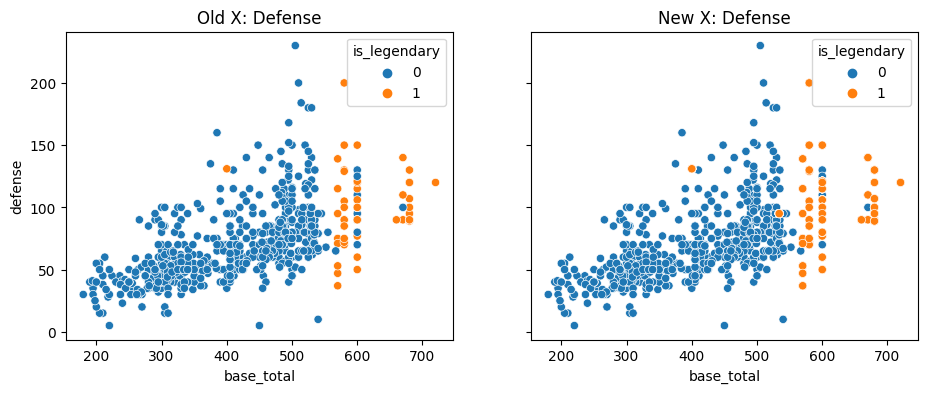

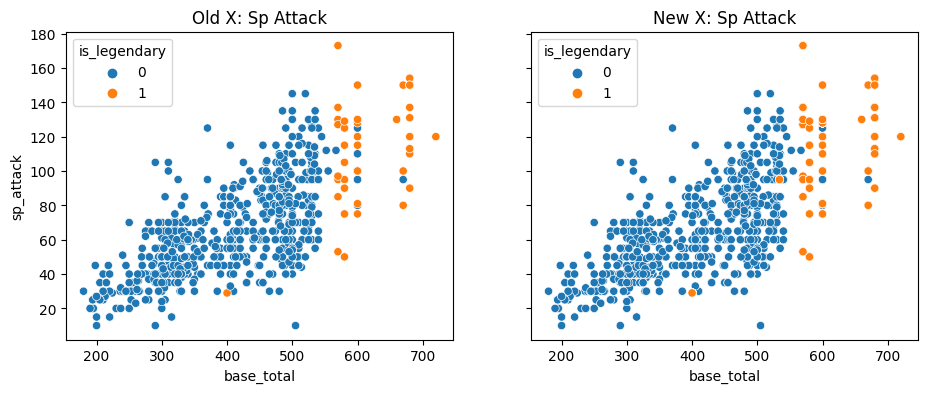

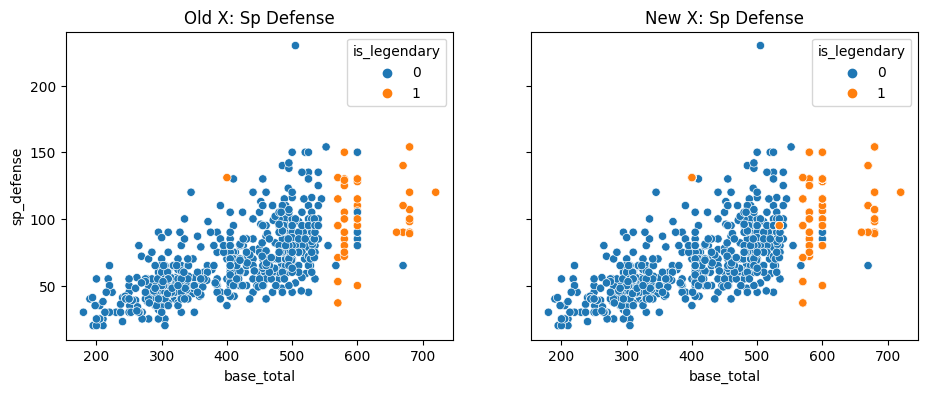

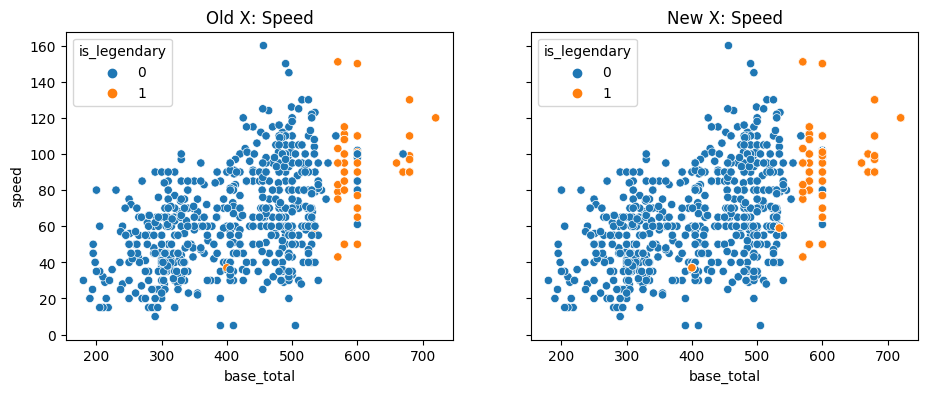

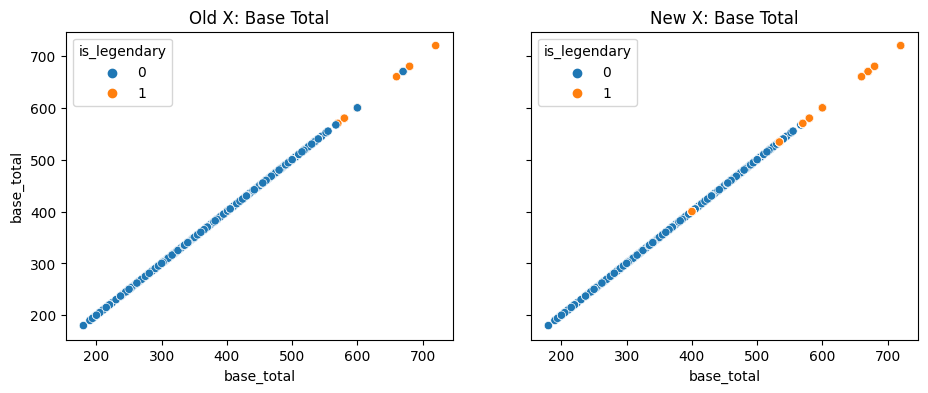

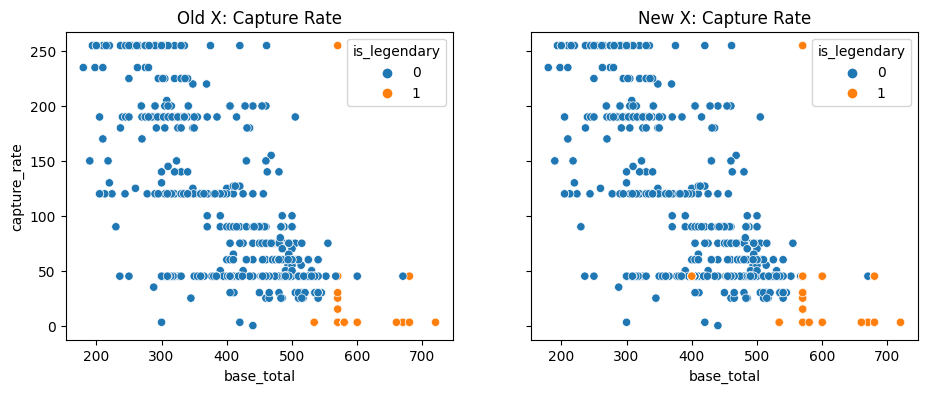

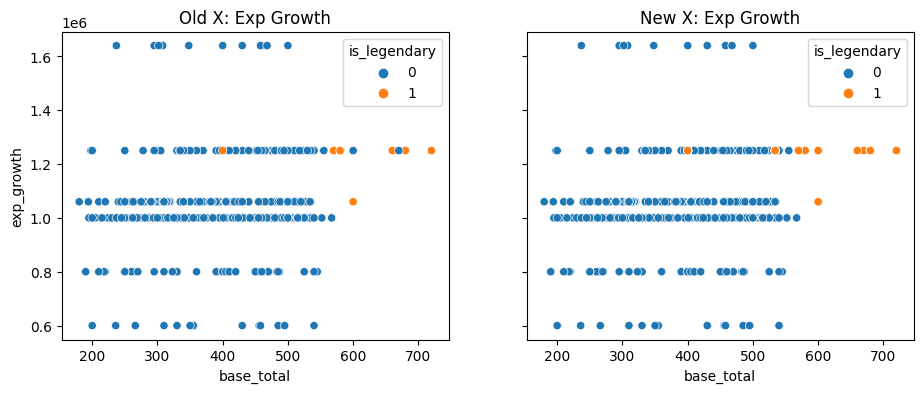

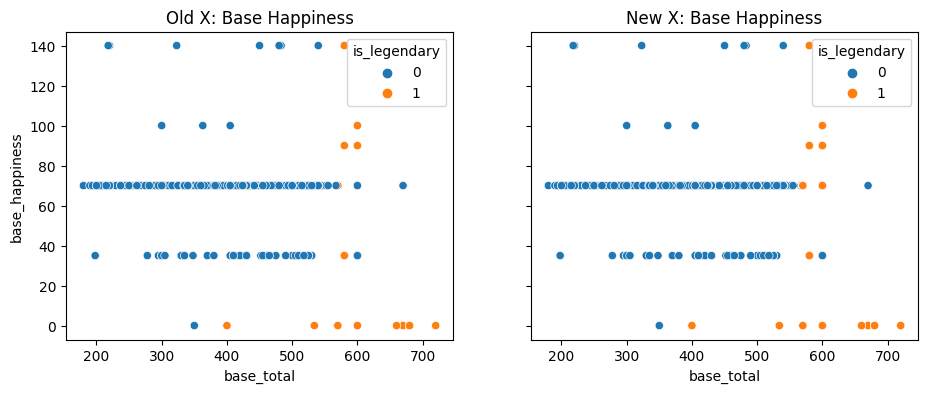

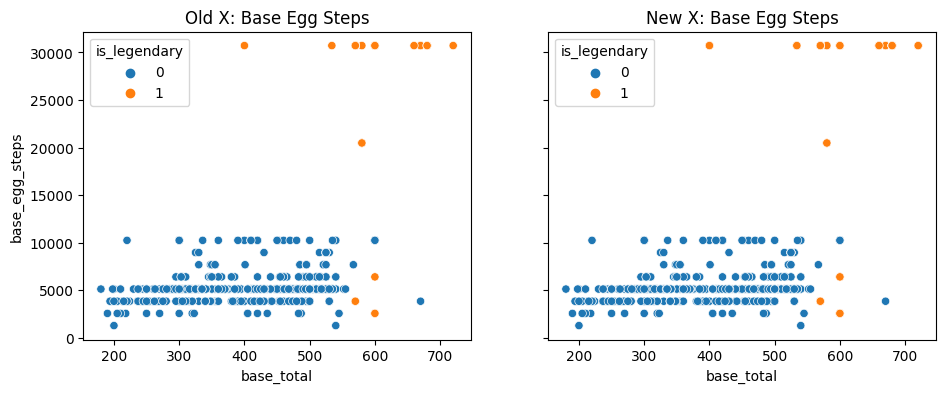

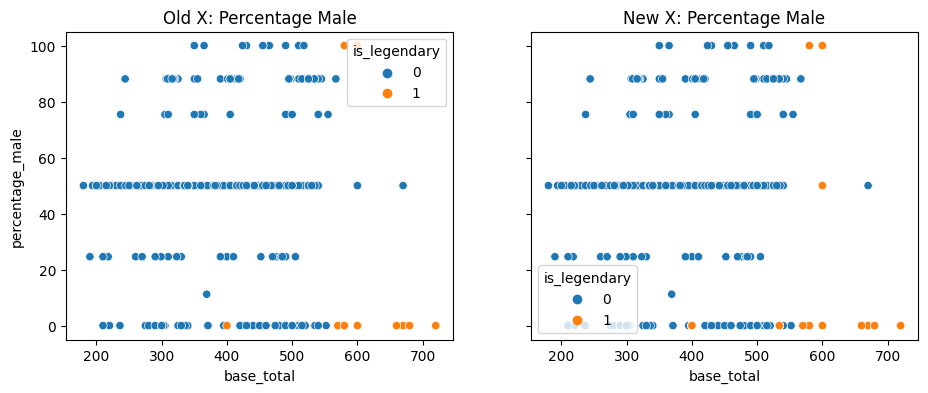

In [145]:
# scatter plots comparing base_total with all other features
for feature in key_features[:15]:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4), sharey=True)
    sns.scatterplot(x=old_X['base_total'], y=old_X[feature], hue=old_y, ax=ax1)
    sns.scatterplot(x=X_train['base_total'], y=X_train[feature], hue=y_train, ax=ax2)
    
    ax1.set_title(f"Old X: {feature.title().replace('_', ' ')}")
    ax2.set_title(f"New X: {feature.title().replace('_', ' ')}")
    plt.show()

In [146]:
print(f"{sum(y_train == 1)} are legendary in y_train")
print(f"{sum(y_train == 0)} are non-legendary in y_train\n")
print(f"New shape of X_train is {X_train.shape}")
print(f"New shape of y_train is {y_train.shape}")

586 are legendary in y_train
586 are non-legendary in y_train

New shape of X_train is (1172, 52)
New shape of y_train is (1172,)


### 3. Model Selection

Because this is binary classification problem, I'll be using [3] classfiier models for practice.

#### Helper Functions

In [147]:
import warnings
warnings.filterwarnings('ignore')


def get_mse(y_true, y_pred):
    """
    Returns prediction MSE 
    """
    return mean_squared_error(y_true, y_pred) / 2


def plot_cf(y_true, y_pred):
    """
    Plots a confusion matrix for given predictions
    """
    f, ax = plt.subplots(figsize=(15, 2))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='magma', ax=ax)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    plt.show()


def plot_double_cf(y_true, y_pred, model, dataset):
    """
    Plots [2] confusion matricies to compare training and cv/test predictions
    """
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 4))
    ax1.set_title(f'Training Predictions')
    
    if dataset.title() == 'Test':
        ax2.set_title(f'TEST Predictions')
    else:
        ax2.set_title(f'CV Predictions')
    
    cm1 = confusion_matrix(y_true[0], y_pred[0])
    cm2 = confusion_matrix(y_true[1], y_pred[1])
    sns.heatmap(cm1, annot=True, fmt='d', cmap='rocket', ax=ax1)
    sns.heatmap(cm2, annot=True, fmt='d', cmap='magma', ax=ax2)
    ax1.set_ylabel('True label')
    ax1.set_xlabel('Predicted label')
    ax2.set_xlabel('Predicted label')
    plt.show()
    
def print_metrics(model, title, X_train, y_train, X_cv, y_cv, dataset):
    """
    Displays certain model metrics and plots the results in a confusion matrix
    """
    y_pred = model.predict(X_cv)

    print(f"---------------------{title.upper()}---------------------")
    print(f"MSE Pred: {get_mse(y_cv, model.predict(X_cv))}")

    y_probas = model.predict_proba(X_cv)
    y_pred_loss = log_loss(y_cv, y_probas)
    
    print(f"Log Loss Pred: {y_pred_loss}")
    print(f"Precision on Pred set: {precision_score(y_cv, y_pred)}")
    print(f"Recall on Pred set: {recall_score(y_cv, y_pred)}")
    print(f"Accuracy score on Training set: {model.score(X_train, y_train)}")
    print(f"Accuracy score on Pred set: {model.score(X_cv, y_cv)}")
    print(f"NULL ACCURACY SCORE ON PRED SET: {max(y_cv.mean(), 1 - y_cv.mean())}")
    
    plot_double_cf((y_train, y_cv), (model.predict(X_train), model.predict(X_cv)), model, dataset)
    
    
def test_params(s, p, c, m, X_train, y_train, X_cv, y_cv):
    """
    Manual grid search for logistic regression
    """
    alg = LogisticRegression(penalty=p, C=c, solver=s, max_iter=m)
    alg.fit(X_train_scaled, y_train)
    pred = alg.predict(X_cv_scaled)
    pred_probas = alg.predict_proba(X_cv_scaled)
    fp, tp, th = roc_curve(y_cv, pred)
    
    new_entry = [
        s,  # current solver,
        p,  # penality
        c,  # current c value
        alg.n_iter_[0],  # point of convergence
        log_loss(y_cv, pred_probas), # log loss
        get_mse(y_cv, pred),  # MSE
        round(auc(fp, tp), 5),  # AUC
        precision_score(y_cv, pred),  # precision score
        recall_score(y_cv, pred),  # recall score
        f1_score(y_cv, pred),  # f1 score
        alg.score(X_train_scaled, y_train),  # training accuracy
        alg.score(X_cv_scaled, y_cv)  # CV accuracy
    ]
    
    return new_entry

In [148]:
# scale training set 
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_cv_scaled = sc.transform(X_cv)
X_test_scaled = sc.transform(X_test)

#### Logistic Regression

In [149]:
# instantiate model
lr_clf = LogisticRegression()
lr_clf.fit(X_train_scaled, y_train)

LogisticRegression()

#### Baseline Metrics

My baseline for testing comparisons will be MSE, Log Loss, and f1. Because the CV/test sets are heavily imbalanced, using accuracy as a metric is ineffectual.

---------------------BASELINE METRICS---------------------
MSE Pred: 0.0078125
Log Loss Pred: 0.0507019634218303
Precision on Pred set: 0.9333333333333333
Recall on Pred set: 0.9333333333333333
Accuracy score on Training set: 0.9991467576791809
Accuracy score on Pred set: 0.984375
NULL ACCURACY SCORE ON PRED SET: 0.8828125


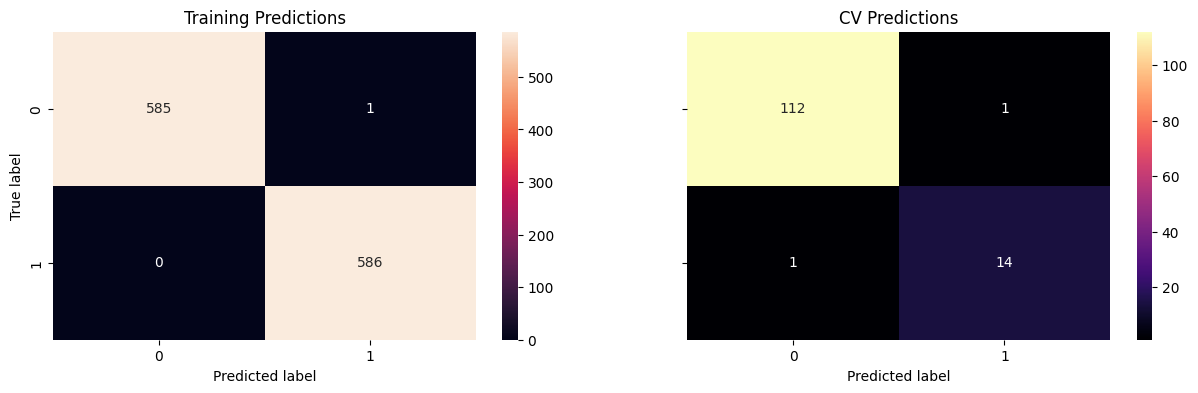

In [150]:
print_metrics(lr_clf, 'BASELINE METRICS', X_train_scaled, y_train, X_cv_scaled, y_cv, 'cv')

#### Manual Parameter Tuning
I'll using my own scoring criteria then afterwards running **GridSearchCV** for comparison.

In [153]:
c_list = np.logspace(-9, 9, 20)
penalty = ['l1', 'l2', 'elasticnet', 'none']
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
# --------------------------------------------------------------------------------------------------------------------
clf_cols = [
    'solver', 'penalty', 'c_param', 'conver', 'log_loss', 'mse', 'auc', 
    'precision', 'recall', 'f1', 'train_accuracy', 'cv_accuracy'
]
clf_df = pd.DataFrame(columns=clf_cols)
row_index = 0

for s in solvers:
    for p in penalty:
        for c in c_list:
            try:
                new_entry = test_params(s, p, c, 10000, X_train_scaled, y_train, X_cv_scaled, y_cv)
            except Exception as e:
                break

            for i, feature in enumerate(clf_cols):
                clf_df.loc[row_index, feature] = new_entry[i]

            row_index += 1

    #         plot_cf((y_train, y_cv), (alg.predict(X_train_scaled), alg.predict(X_cv_scaled)), c)
        

# ---------------------BASELINE METRICS---------------------
# MSE Pred: 0.0078125
# Log Loss Pred: 0.0507019634218303
# Precision on Pred set: 0.9333333333333333
# Recall on Pred set: 0.9333333333333333
# Accuracy score on Training set: 0.9991467576791809
# Accuracy score on Pred set: 0.984375
# NULL ACCURACY SCORE ON PRED SET: 0.8828125

# previous best:
# liblinear	l1	0.335982	12	0.022317	0.0	1.0	1.0	1.0	1.0	0.996587	1.0

In [154]:
clf_df.sort_values(['log_loss'], ascending=True).head(3)  
# only showing [3] entries to show example of what dataframe looks like

,solver,penalty,c_param,conver,log_loss,mse,auc,precision,recall,f1,train_accuracy,cv_accuracy
49,liblinear,l1,0.335982,12,0.022317,0.0,1.0,1.0,1.0,1.0,0.996587,1.0
209,saga,l1,0.335982,993,0.022532,0.003906,0.96667,1.0,0.933333,0.965517,0.99744,0.992188
69,liblinear,l2,0.335982,7,0.042603,0.007812,0.96224,0.933333,0.933333,0.933333,0.99744,0.984375


In [155]:
best_estimator = clf_df.iloc[49]

Solver: liblinear, Penalty: l1, C: 0.33598182862837744


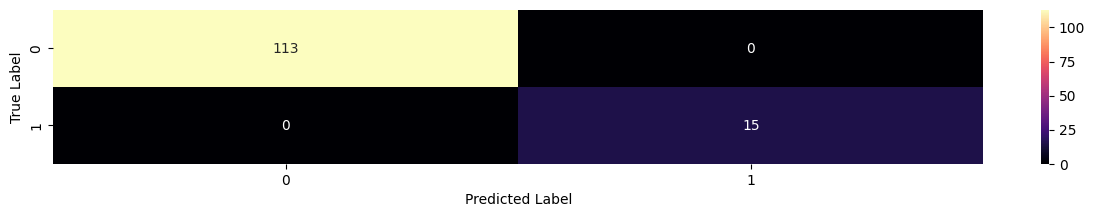

In [156]:
# optimal manual tuning estimator
s, p, c = best_estimator[:3]

m_lr_clf = LogisticRegression(solver=s, penalty=p, C=c)
m_lr_clf.fit(X_train_scaled, y_train)
print(f"Solver: {s}, Penalty: {p}, C: {c}")

# test model with CV data
plot_cf(y_cv, m_lr_clf.predict(X_cv_scaled))

#### Grid Search

In [157]:
# parameters to tune
params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-9, 9, 20),  # using the same params as manual tuning
    'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
    'max_iter': [10000]
}

In [158]:
# run GridSearch on training set
lr = LogisticRegression()
grid = GridSearchCV(lr, params, cv=3, scoring='f1', verbose=True)
grid.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-09, 8.85866790e-09, 7.84759970e-08, 6.95192796e-07,
       6.15848211e-06, 5.45559478e-05, 4.83293024e-04, 4.28133240e-03,
       3.79269019e-02, 3.35981829e-01, 2.97635144e+00, 2.63665090e+01,
       2.33572147e+02, 2.06913808e+03, 1.83298071e+04, 1.62377674e+05,
       1.43844989e+06, 1.27427499e+07, 1.12883789e+08, 1.00000000e+09]),
                         'max_iter': [10000],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag',
                                    'saga']},
             scoring='f1', verbose=True)

Score: 0.9940713429490092
Params: {'C': 0.33598182862837744, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear'}


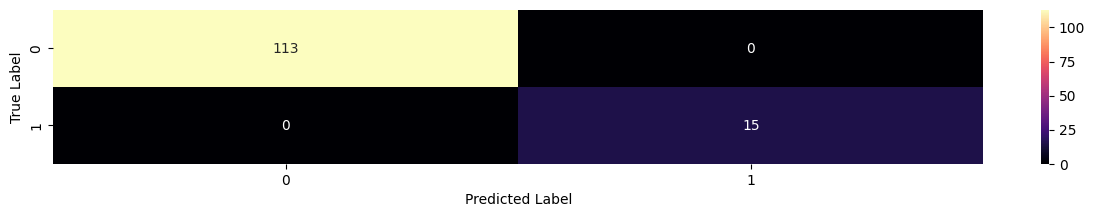

In [159]:
# get best model
gs_lr_clf = grid.best_estimator_
print(f"Score: {grid.best_score_}")
print(f"Params: {grid.best_params_}")

gs_lr_clf.fit(X_train_scaled, y_train)

# test model with CV data
plot_cf(y_cv, gs_lr_clf.predict(X_cv_scaled))

# previous
# Score: 0.9940713429490092
# Params: {'C': 0.33598182862837744, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear'}

#### XGBClassifier

In [160]:
# baseline model
xgb = XGBClassifier()
xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

---------------------BASELINE METRICS---------------------
MSE Pred: 0.0
Log Loss Pred: 0.0011698364288993408
Precision on Pred set: 1.0
Recall on Pred set: 1.0
Accuracy score on Training set: 1.0
Accuracy score on Pred set: 1.0
NULL ACCURACY SCORE ON PRED SET: 0.8828125


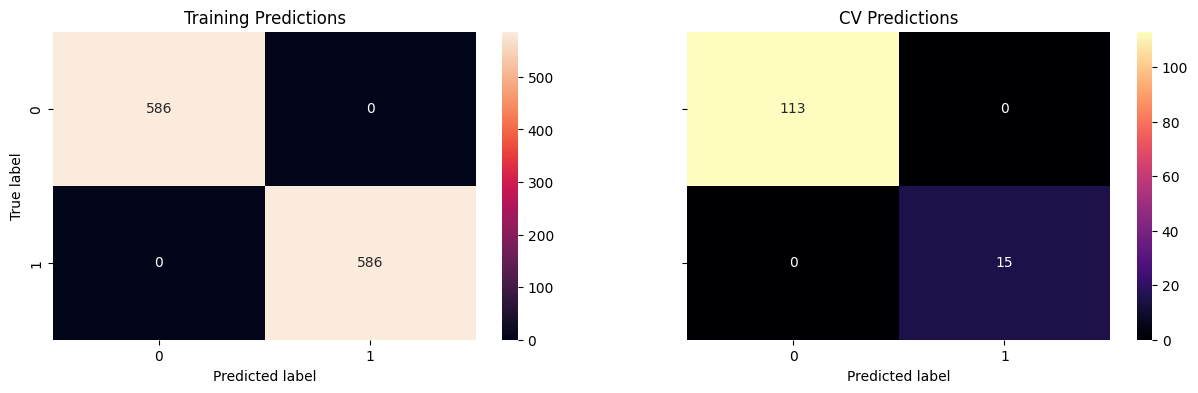

In [161]:
print_metrics(xgb, 'BASELINE METRICS', X_train_scaled, y_train, X_cv_scaled, y_cv, 'CV')

#### Randomized Grid Search

In [163]:
# parameters to tune
params = {
    'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'max_depth': np.arange(16),
    'min_child_weight': [1, 3, 5, 7, 9],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7]
}


# ---------------------BASELINE METRICS---------------------
# MSE Pred: 0.0
# Log Loss Pred: 0.0011698364288993408
# Precision on Pred set: 1.0
# Recall on Pred set: 1.0
# Accuracy score on Training set: 1.0
# Accuracy score on Pred set: 1.0
# NULL ACCURACY SCORE ON PRED SET: 0.8828125

In [164]:
# run RS on training set
random_grid = RandomizedSearchCV(
    XGBClassifier(), param_distributions=params, n_iter=500, scoring='f1', n_jobs=-1, cv=5, verbose=True
)
random_grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5, 0.6,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                                        'min_child_weight': [1, 3, 5, 7, 9]},
                   scoring='f1', verbose=True)

Score: 0.9991489361702127
Params: {'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.3, 'gamma': 0.4, 'colsample_bytree': 0.4}


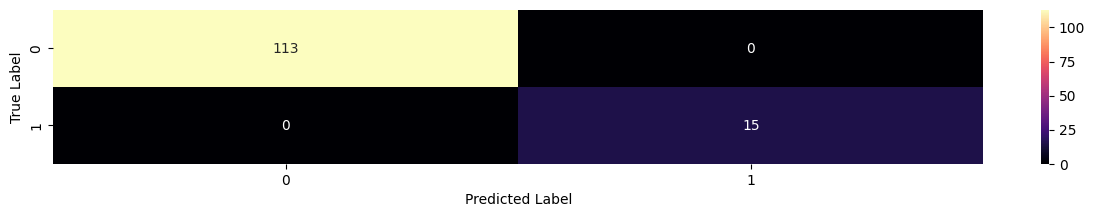

In [165]:
print(f"Score: {random_grid.best_score_}")
print(f"Params: {random_grid.best_params_}")

rs_xgb_clf = random_grid.best_estimator_
rs_xgb_clf.fit(X_train_scaled, y_train)

plot_cf(y_cv, rs_xgb_clf.predict(X_cv_scaled))

# previous best:
# Score: 0.9991489361702127
# Params: {'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.3, 'gamma': 0.4, 'colsample_bytree': 0.4}

#### Feature Importance

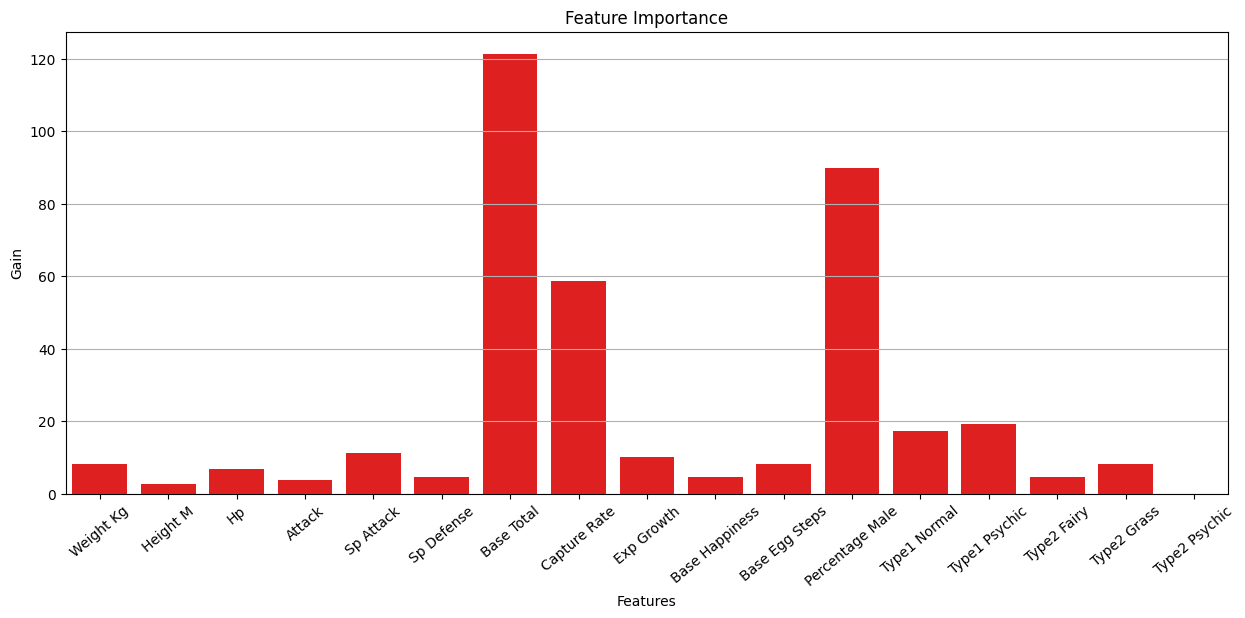

In [176]:
gain_importance = rs_xgb_clf.get_booster().get_score(importance_type='gain')
x, y = [], []

for k, v in gain_importance.items():
    index = int(k.split('f')[1])
    x.append(key_features[index].title().replace('_', ' '))
    y.append(v)

plt.figure(figsize=(15, 6))
plt.title('Feature Importance')
plt.grid(True)
sns.barplot(x=x, y=y, color='red')
plt.ylabel('Gain')
plt.xlabel('Features')
plt.xticks(rotation=40)
plt.show()

### 4. Compare Models

---------------------MANUAL LR ESTIMATOR---------------------
MSE Pred: 0.0
Log Loss Pred: 0.03150430451199377
Precision on Pred set: 1.0
Recall on Pred set: 1.0
Accuracy score on Training set: 0.9965870307167235
Accuracy score on Pred set: 1.0
NULL ACCURACY SCORE ON PRED SET: 0.9090909090909091


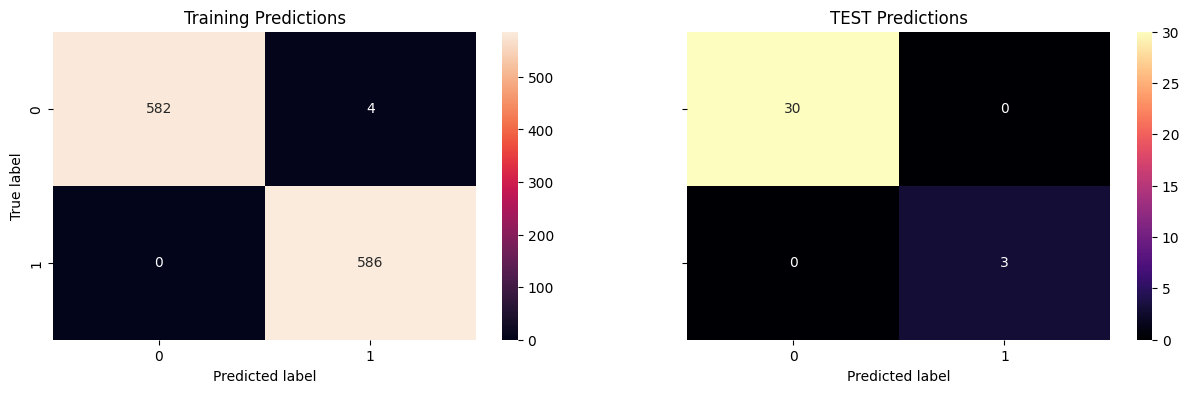

---------------------RANDOM SEARCH BEST XGB ESTIMATOR---------------------
MSE Pred: 0.0
Log Loss Pred: 0.0016482519002959683
Precision on Pred set: 1.0
Recall on Pred set: 1.0
Accuracy score on Training set: 1.0
Accuracy score on Pred set: 1.0
NULL ACCURACY SCORE ON PRED SET: 0.9090909090909091


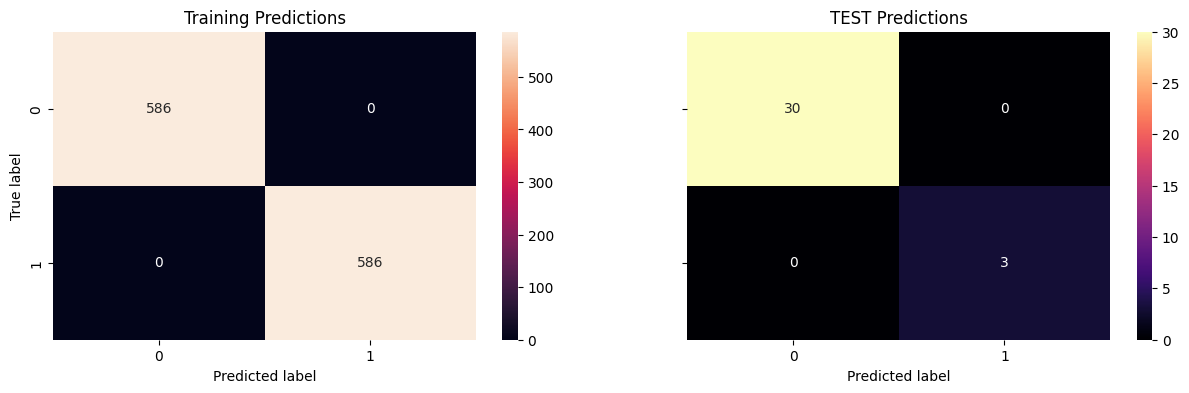

---------------------GRID SEARCH BEST LR ESTIMATOR---------------------
MSE Pred: 0.0
Log Loss Pred: 0.03128310338077559
Precision on Pred set: 1.0
Recall on Pred set: 1.0
Accuracy score on Training set: 0.9965870307167235
Accuracy score on Pred set: 1.0
NULL ACCURACY SCORE ON PRED SET: 0.9090909090909091


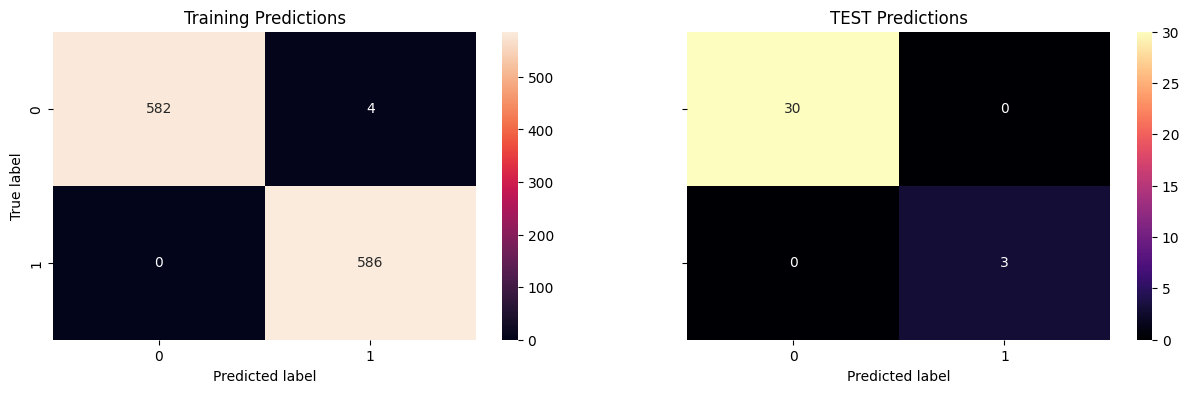

In [167]:
# run models with test set
print_metrics(m_lr_clf, 'manual LR estimator', X_train_scaled, y_train, X_test_scaled, y_test, 'test')
print_metrics(rs_xgb_clf, 'random search best XGB estimator', X_train_scaled, y_train, X_test_scaled, y_test, 'test')
print_metrics(gs_lr_clf, 'grid search best LR estimator', X_train_scaled, y_train, X_test_scaled, y_test, 'test')

### 5. Interface Demo

In [168]:
def read_model(index):
    if index == 0:
        return 'MANUAL'
    elif index == 1:
        return 'XGB'
    else:
        return 'GRIDSEARCH'

In [174]:
pokemon = input(f"Enter Pokémon name: ").title()
data = sc.transform(df_ohe[df_ohe['name'] == pokemon][key_features])

xgb_result = rs_xgb_clf.predict(data)
lr_result = m_lr_clf.predict(data)
gs_result = gs_lr_clf.predict(data)
print('MANUAL:', m_lr_clf.predict_proba(data))
print('GRIDSEARCH:', gs_lr_clf.predict_proba(data))
print('XGB', rs_xgb_clf.predict_proba(data), '\n')

results = [lr_result, xgb_result, gs_result]
for index, res in enumerate(results):
    if res == 1:
        print(f"{read_model(index)}: {pokemon} is a legendary!")
    else:
        print(f"{read_model(index)}: {pokemon} is not a legendary.")

Enter Pokémon name: Lunala
MANUAL: [[1.20280883e-04 9.99879719e-01]]
GRIDSEARCH: [[1.17140115e-04 9.99882860e-01]]
XGB [[0.00133681 0.9986632 ]] 

MANUAL: Lunala is a legendary!
XGB: Lunala is a legendary!
GRIDSEARCH: Lunala is a legendary!


### Conclusion

Clearly I suck at manually tuning a model lol 😅 the XGBClassifier has the most consistent accuracy by far, followed by the Grid Search logistic regression model.

During this project I learned how to:
- Analyse imbalanced data
- Use One-Hot Encoding
- Implement feature selection
- Use over-sampling
- Plot confusion matrices
- Use GridSearch and RandomizedGridSearch
- Compare metrics
- Train and anaylse different models